In [ ]:
import os
import re
import sys
import time
import tqdm
import string
import argparse
import datetime
import textwrap
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
# turn off lxml warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
# pytrials
from utils.drug_search import read_pytrials_fields
from pytrials.client import ClinicalTrials
# urllib / BeautifulSoup
import urllib.request, urllib.parse, urllib.error
from bs4 import BeautifulSoup
# custom functions
from utils.webpage_scraping import test_connection
from utils.pickle_dataframes import unpickle_dataframes
from utils.ctgov_search import get_ctgov_synonyms
from utils.drug_search import ctgov_search, find_drug_multiple_fields
from utils.fda_sponsors import fda_sponsor_list, rename_sponsors
from utils.pubchem_search import search_pubchem
from utils.fda_api_search import scrape_fda_data, fda_api_dict_to_df
%load_ext autoreload
%autoreload 2

def pubmed_links_parser(pubmed_links):
	'''
	linksParser reads each URL from PMID_ListGenerator output 
	and parses specified info
	'''
	articleCount = 0; abstract_text = []
	searchesHash = defaultdict(lambda: defaultdict(list)) # primary key = PMID
	for link in tqdm.tqdm(pubmed_links):
		searchHash = defaultdict(str)
		authorAffiliationDict = defaultdict(list)
		affiliationDict = defaultdict(str)
		searchHash['articleCount'] = articleCount
		articleCount += 1
		# Open, read and process link through BeautifulSoup
		r1 = urllib.request.urlopen(link).read()
		soup = BeautifulSoup(r1, "html.parser")
		# Add link to searchHash
		searchHash['search_link'] = link
		# ARTICLE NAME Parser
		article_title = soup.find('title').text
		searchHash['article_title'] = article_title
		# META INFO (journal title, date published)
		meta = soup.find_all('meta')
		author_list = []
		author_institutions = []
		for tag in meta:
			if 'name' in tag.attrs.keys():
				if tag.attrs['name'] == 'citation_journal_title':
					searchHash['journal_title'] = tag.attrs['content']
				elif tag.attrs['name'] == 'citation_journal_abbrev':
					searchHash['journal_title_abv'] = tag.attrs['content']
				elif tag.attrs['name'] == 'citation_publisher':
					searchHash['publisher'] = tag.attrs['content']
				elif tag.attrs['name'] == 'citation_abstract':
					searchHash['abstract'] = tag.attrs['content']
				elif tag.attrs['name'] == 'citation_keywords':
					keywords_uncleaned = tag.attrs['content'].split(';')
					keywords = [keyword.strip().rstrip('.').lower() for keyword in keywords_uncleaned]
					searchHash['keywords'] = keywords
				elif tag.attrs['name'] == 'citation_publication_date' or tag.attrs['name'] == 'citation_online_date':
					if len(tag.attrs['content'].split('/')) == 2: # date format (YYYY/MM)
						tag.attrs['content'] = tag.attrs['content'].split('/')[0]
					searchHash['publication_date'] = tag.attrs['content']
				elif tag.attrs['name'] == 'citation_author':
					author_list.append(tag.attrs['content'])
				elif tag.attrs['name'] == 'citation_author_institution':
					author_institutions.append(tag.attrs['content'])
				elif tag.attrs['name'] == 'citation_pmid':
					PMID = tag.attrs['content']
				elif tag.attrs['name'] == 'citation_doi':
					searchHash['doi'] = 'doi.org/' + tag.attrs['content']
		searchHash['authors'] = author_list
		searchHash['author_institutions'] = author_institutions
		searchesHash[PMID] = searchHash
		# pause for a second to avoid overloading the server
		time.sleep(1)
	return searchesHash

def load_databases():
	print(f'Loading Database...')
	df_dict = unpickle_dataframes(database_folder='databases')
	return df_dict

def read_pdf(report_path, pdf_dir, pdf_name):
	print(f'  Reading {pdf_name}')
	# process using llama3.2

def ordered_df(df_key):
	order_by_dict = {
		'combined_fda_df': ['fda_year', 'fda_year_approval_count'],
		'ctgov_df': ['Study Title'],
		'dailymed_df': ['drug_name'],
	}
	if df_key in order_by_dict.keys():
		return order_by_dict[df_key]
	else:
		return order_by_dict['combined_fda_df']

def flatten_list(l):
	for el in l:
		if isinstance(el, list):
			yield from flatten_list(el)
		else:
			yield el

df_keys_dict = \
	{'ctgov_df': 
		['search_term', 'NCT Number', 'Study Title', 'Study URL', 'Acronym',
		 'Study Status', 
		#  'Brief Summary', 
		 'Study Results', 'Conditions',
     'Interventions', 'Sponsor', 'Collaborators', 'Phases', 'Enrollment', 
		 'Funder Type', 'Study Type', 
		 'Start Date', 'Primary Completion Date', 'Completion Date', 
		 'First Posted', 'Results First Posted', 'Last Update Posted', 
		 'Locations', 'Study Documents'],
	}

def df_cols(df_key):
	if df_key in df_keys_dict.keys():
		return df_keys_dict[df_key]

def create_markdown(
	company_name,
	results_dir='results',
):
	if not os.path.exists(results_dir):
		os.makedirs(results_dir)
	report_path = os.path.join(results_dir, f'{company_name}.md')
	print(f'Creating {report_path}')
	with open(report_path, 'w') as f:
		f.write(f'# {company_name}')
		date = datetime.date.today()
		date_formatted = date.strftime('%B %d, %Y')
		f.write(f'\n## {date_formatted}\n\n')
	return report_path

def get_pubmed_info(pubmed_ids):
	pubmed_links = [f'https://pubmed.ncbi.nlm.nih.gov/{pubmed_id}' for pubmed_id in pubmed_ids]
	pubmed_dict = pubmed_links_parser(pubmed_links)
	# sort by publication date
	pubmed_dict = dict(sorted(pubmed_dict.items(), key=lambda item: item[1]['publication_date'], reverse=True))
	return pubmed_dict

def write_pubchem_to_markdown(df, drug_name, active_ingredient, file):
	# write the pubchem dataframe to markdown
	cols = df.columns
	with open(file, 'a') as f:
		f.write(f'### PubChem Search: {drug_name} ({active_ingredient})\n\n')
		f.write(f'#### Summary\n\n')
		if len(df) > 0:
			for col in cols:
				if col == 'pubmed_ids':
					if df[col].iloc[0] != None:
						pubmed_ids = df[col].iloc[0]
						pubmed_dict = get_pubmed_info(pubmed_ids)
					else:
						pubmed_dict = {}
				else:
					text = f'> * **{col}:** {df[col].iloc[0]}'
					f.write(f'{text}\n')
			# write pubmed articles at the end
			if len(pubmed_dict) > 0:
				f.write(f'\n#### Pubmed Articles\n')
				for pmid, pmid_info in pubmed_dict.items():
					f.write(f'> **[{pmid_info["article_title"]}]({pmid_info["search_link"]})**\n')
					f.write(f'> * **Published**: {pmid_info["publication_date"]}\n')
					f.write(f'> * **Journal**: *{pmid_info["journal_title"]}*\n')
					abstract = pmid_info["abstract"]
					# remove HTML tags (i.e. <h3>, <p>, <i>, etc.)
					abstract = re.sub(r'<[^>]*>', '', abstract)
					f.write(f'> * **Abstract**: {abstract}\n')
					f.write('\n')
			else:
				f.write('> * No Pubmed Articles Found\n')
		else:
			f.write('> * No PubChem Results Found\n')
		# return file still open
		return f

def write_fda_to_markdown(f, df, search_term, cols, sort_by):
	f.write(f'#### {search_term}\n')
	f.write(f'**FDA Approvals**\n\n')
	if len(df) == 1:
		f.write(df[cols].to_markdown(index=False))
	if len(df) > 1:
		df = df.sort_values(by=ordered_df(sort_by), ascending=False)
		f.write(df[cols].to_markdown(index=False))
	else:
		f.write('> * No Approved Drugs Found\n')
	f.write('\n\n')

def plot_sponsors_report(
		df, 
		drug_name_field='drug_name', 
		sponsor_field='sponsor', 
		unique_drugs_only=True
	):
	# drop any rows that have the exact same (drug_name, sponsor) pair
	if unique_drugs_only and drug_name_field:
		df_sponsors = df.copy().drop_duplicates(subset=[drug_name_field, sponsor_field])
	else:
		df_sponsors = df.copy()
	sponsors = df_sponsors[sponsor_field]
	# drop any nan values
	sponsors = [sponsor for sponsor in sponsors if sponsor != '']
	if len(sponsors) == 0:
		print('No sponsors found')
		return
	# count the number of unique sponsors from a list where value_counts() cannot be used
	top_sponsors = pd.Series(sponsors).value_counts().nlargest(50)
	# plot
	f, axarr = plt.subplots(1, 2, dpi=300)
	top_sponsor_names = top_sponsors.index
	top_sponsor_counts = top_sponsors.values
	print(list(zip(top_sponsor_names, top_sponsor_counts)))
	# make bar edges black
	axarr[0].bar(top_sponsor_names, top_sponsor_counts, edgecolor='black')
	# rotate x-axis labels
	axarr[0].set_xticks(range(len(top_sponsor_names)))
	top_sponsors_truncated = [textwrap.shorten(sponsor, width=30, placeholder='...') for sponsor in top_sponsor_names]
	axarr[0].set_xticklabels(top_sponsors_truncated, rotation=90, fontsize=6, fontname='Optima')
	# show each sponsor on x-axis
	axarr[0].set_xlabel('Sponsor', fontsize=12, fontweight='bold', fontname='Optima')
	axarr[0].set_ylabel('Number of Drugs', fontsize=12, fontweight='bold', fontname='Optima')
	plt.tight_layout()
	# make sure nothing is cut off
	plt.subplots_adjust(bottom=0.6, top=0.9)
	# create a second plot with the same bar plot but with Phases on the x-axis and sort by Phases (i.e. PHASE1, PHASE2, PHASE3, PHASE4)
	phases = df['Phases']
	phases = [phase for phase in phases if phase != '']
	# sort the phases
	phases = sorted(list(set(phases)))
	# plot a bar graph of the number of drugs in each phase
	top_phases = pd.Series(phases).value_counts()
	top_phase_names = top_phases.index
	top_phase_counts = top_phases.values
	# plot the number of drugs in each phase
	axarr[1].bar(top_phase_names, top_phase_counts, edgecolor='black', color='lightgreen')
	# rotate x-axis labels
	axarr[1].set_xticks(range(len(top_phase_names)))
	axarr[1].set_xticklabels(top_phase_names, rotation=90, fontsize=6, fontname='Optima')
	# show each sponsor on x-axis
	axarr[1].set_xlabel('Phases', fontsize=16, fontweight='bold', fontname='Optima')
	axarr[1].set_ylabel('Number of Drugs', fontsize=16, fontweight='bold', fontname='Optima')
	# set yticks to be integers with only 0 and the max value
	axarr[1].set_yticks([0, max(top_phase_counts)])
	# make sure nothing is cut off
	plt.tight_layout()
	return f

def write_ctgov_to_markdown(f, ctgov_df):
	search_terms = list(flatten_list([ctgov_df['Search Term'].values]))[0]
	search_terms = list(set(flatten_list(search_terms)))
	print(f'  Number of synonyms in ctgov: {len(search_terms)}')
	file_path = f.name
	with open(file_path, 'a') as f:
		f.write('\n#### Clinical Trials\n\n')
		for search_term in search_terms:
			ctgov_link = f'https://clinicaltrials.gov/search?term={search_term}'
			df = ctgov_df[ctgov_df['Search Term'].apply(lambda x: search_term in x)]
			# standardize sponsor names
			df = rename_sponsors(df, drug_name_field='NCT Number', sponsor_field='Sponsor')
			# plot sponsors
			sponsor_figure = plot_sponsors_report(
				df, 
				drug_name_field=None, 
				sponsor_field='Sponsor', 
				unique_drugs_only=False
			)
			f.write(f'**{search_term} ([link]({ctgov_link}))**\n')
			min_sponsor_count = 10
			if sponsor_figure is not None and len(df) > min_sponsor_count:
				# get directory name for file
				dir_name = os.path.join(os.path.dirname(file_path), 'images')
				# make the directory if it doesn't exist
				if not os.path.exists(dir_name):
					os.makedirs(dir_name)
				figure_path = os.path.join(dir_name, f'sponsor_plot_{search_term}.png')
				sponsor_figure.savefig(figure_path)
				f.write(f'![sponsor_plot](images/sponsor_plot_{search_term}.png)')
				f.write('\n')
			# sort dataframe by most recent start date and write the date, title, and sponsor to the markdown file
			cols = ['Start Date', 'Completion Date', 'NCT Number', 'Study Title', 'Sponsor', 'Phases', 'Conditions']
			ct_dates_df = pd.DataFrame(columns=cols)
			first_date_info = df.sort_values(by='Start Date', ascending=True).iloc[0][cols]
			ct_dates_df = pd.concat([ct_dates_df, pd.DataFrame(first_date_info).T], axis=0)
			if len(df) > 1:
				last_date_info = df.sort_values(by='Start Date', ascending=False).iloc[0][cols]
				ct_dates_df = pd.concat([ct_dates_df, pd.DataFrame(last_date_info).T], axis=0)
			# conver all 'NCT Number' to links
			ct_dates_df['NCT Number'] = ct_dates_df['NCT Number'].apply(lambda x: f'[{x}](https://clinicaltrials.gov/study/{x})')
			f.write(ct_dates_df.to_markdown(index=False))
			f.write('\n\n')

def synonym_ctgov_search(pubchem_df):
	if len(pubchem_df) > 0:
		ctgov_df = get_ctgov_synonyms(pubchem_df)
		return ctgov_df

def default_search(
		df_dict, 
		f, 
		company_name='Gateway Neuroscience',
		drug_name='zelquistinel', 
		active_ingredient='NMDAR', 
		search_terms=['cancer']
):
	# search for drug/active ingredient in pubchem
	print(f'PubChem Search: {drug_name} ({active_ingredient})')
	pubchem_df = search_pubchem(
		pd.DataFrame(
			columns=["drug_name", "active_ingredient"], 
			data=[[drug_name, active_ingredient]]),
		save_df=False
	)
	f = write_pubchem_to_markdown(pubchem_df, drug_name, active_ingredient, f)
	
	# search for synonyms in ctgov
	ctgov_df = synonym_ctgov_search(pubchem_df)
	write_ctgov_to_markdown(f, ctgov_df)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
def main(
		pdf_name = 'Gate Neurosciences Series B - September 2024.pdf', 
		company_name = 'Gateway Neuroscience',
		drug_name = 'zelquistinel',
		active_ingredient = 'NMDAR',
		search_terms = ['neurodegeneration']
	):

	df_dict = load_databases()
	report_path = create_markdown(company_name)

	# LLM processing of PDF
	read_pdf(
		report_path, 
		pdf_dir='diligence_examples', 
		pdf_name=pdf_name
	)
	# search for terms in the databases
	ctgov_df = default_search(
		df_dict, 
		report_path,
		company_name = company_name,
		drug_name = drug_name,
		active_ingredient = active_ingredient, 
		search_terms = search_terms
	)
	return ctgov_df

Loading Database...
Number of pickled files found: 12
  combined_fda_df dataframe shape: (543, 18)
  ctgov_df dataframe shape: (46051, 32)
  dailymed_df dataframe shape: (260228, 6)
  ddc_df dataframe shape: (9332, 20)
  ddc_drug_classes dataframe shape: (8093, 20)
  ddc_drugs dataframe shape: (1239, 13)
  fda_api_df dataframe shape: (543, 73)
  fda_approved_ddc dataframe shape: (28317, 29)
  fda_approved_df dataframe shape: (28317, 7)
  fda_biologics_df dataframe shape: (472, 11)
  fda_ddc_df dataframe shape: (543, 40)
  pubchem_df dataframe shape: (543, 8)
Creating results/Novo Nordisk.md
  Reading Gate Neurosciences Series B - September 2024.pdf
PubChem Search: ozempic (semaglutide)
Getting drug info for ozempic (semaglutide)...(1/1)
  CID: 56843331 | Synonyms 33
Number of drugs with CID: 1/1
Number of drugs with SID: 1/1
  Drugs missing SID:
  None


100%|██████████| 9/9 [00:14<00:00,  1.57s/it]


Number of synonyms for ozempic: 33
    CTs found: 1465
  Number of synonyms in ctgov: 13
Found 4/4 sponsors
  0 NCT00696657          Novo Nordisk A/S -> Novo
  1 NCT00851773          Novo Nordisk A/S -> Novo
  2 NCT00813020          Novo Nordisk A/S -> Novo
  3 NCT00833716          Novo Nordisk A/S -> Novo
[('Novo Nordisk A/S', 4)]
Found 1224/1224 sponsors
  0 NCT06468748          United States Army Research Institute of Environmental Medicine -> United
  1 NCT02064348          Novo Nordisk A/S -> Novo
  2 NCT05996848          Novo Nordisk A/S -> Novo
  3 NCT06489457          University Medical Centre Ljubljana -> University Medical Centre Ljubljana
  4 NCT04979130          University of Colorado, Denver -> University Of Colorado Denver
  5 NCT03693430          Novo Nordisk A/S -> Novo
  6 NCT06492330          Shanghai Jiao Tong University School of Medicine -> Shanghai Jiao Tong University School Of Medicine
  7 NCT04200625          University of Miami -> University Of Miami
  8 NCT06

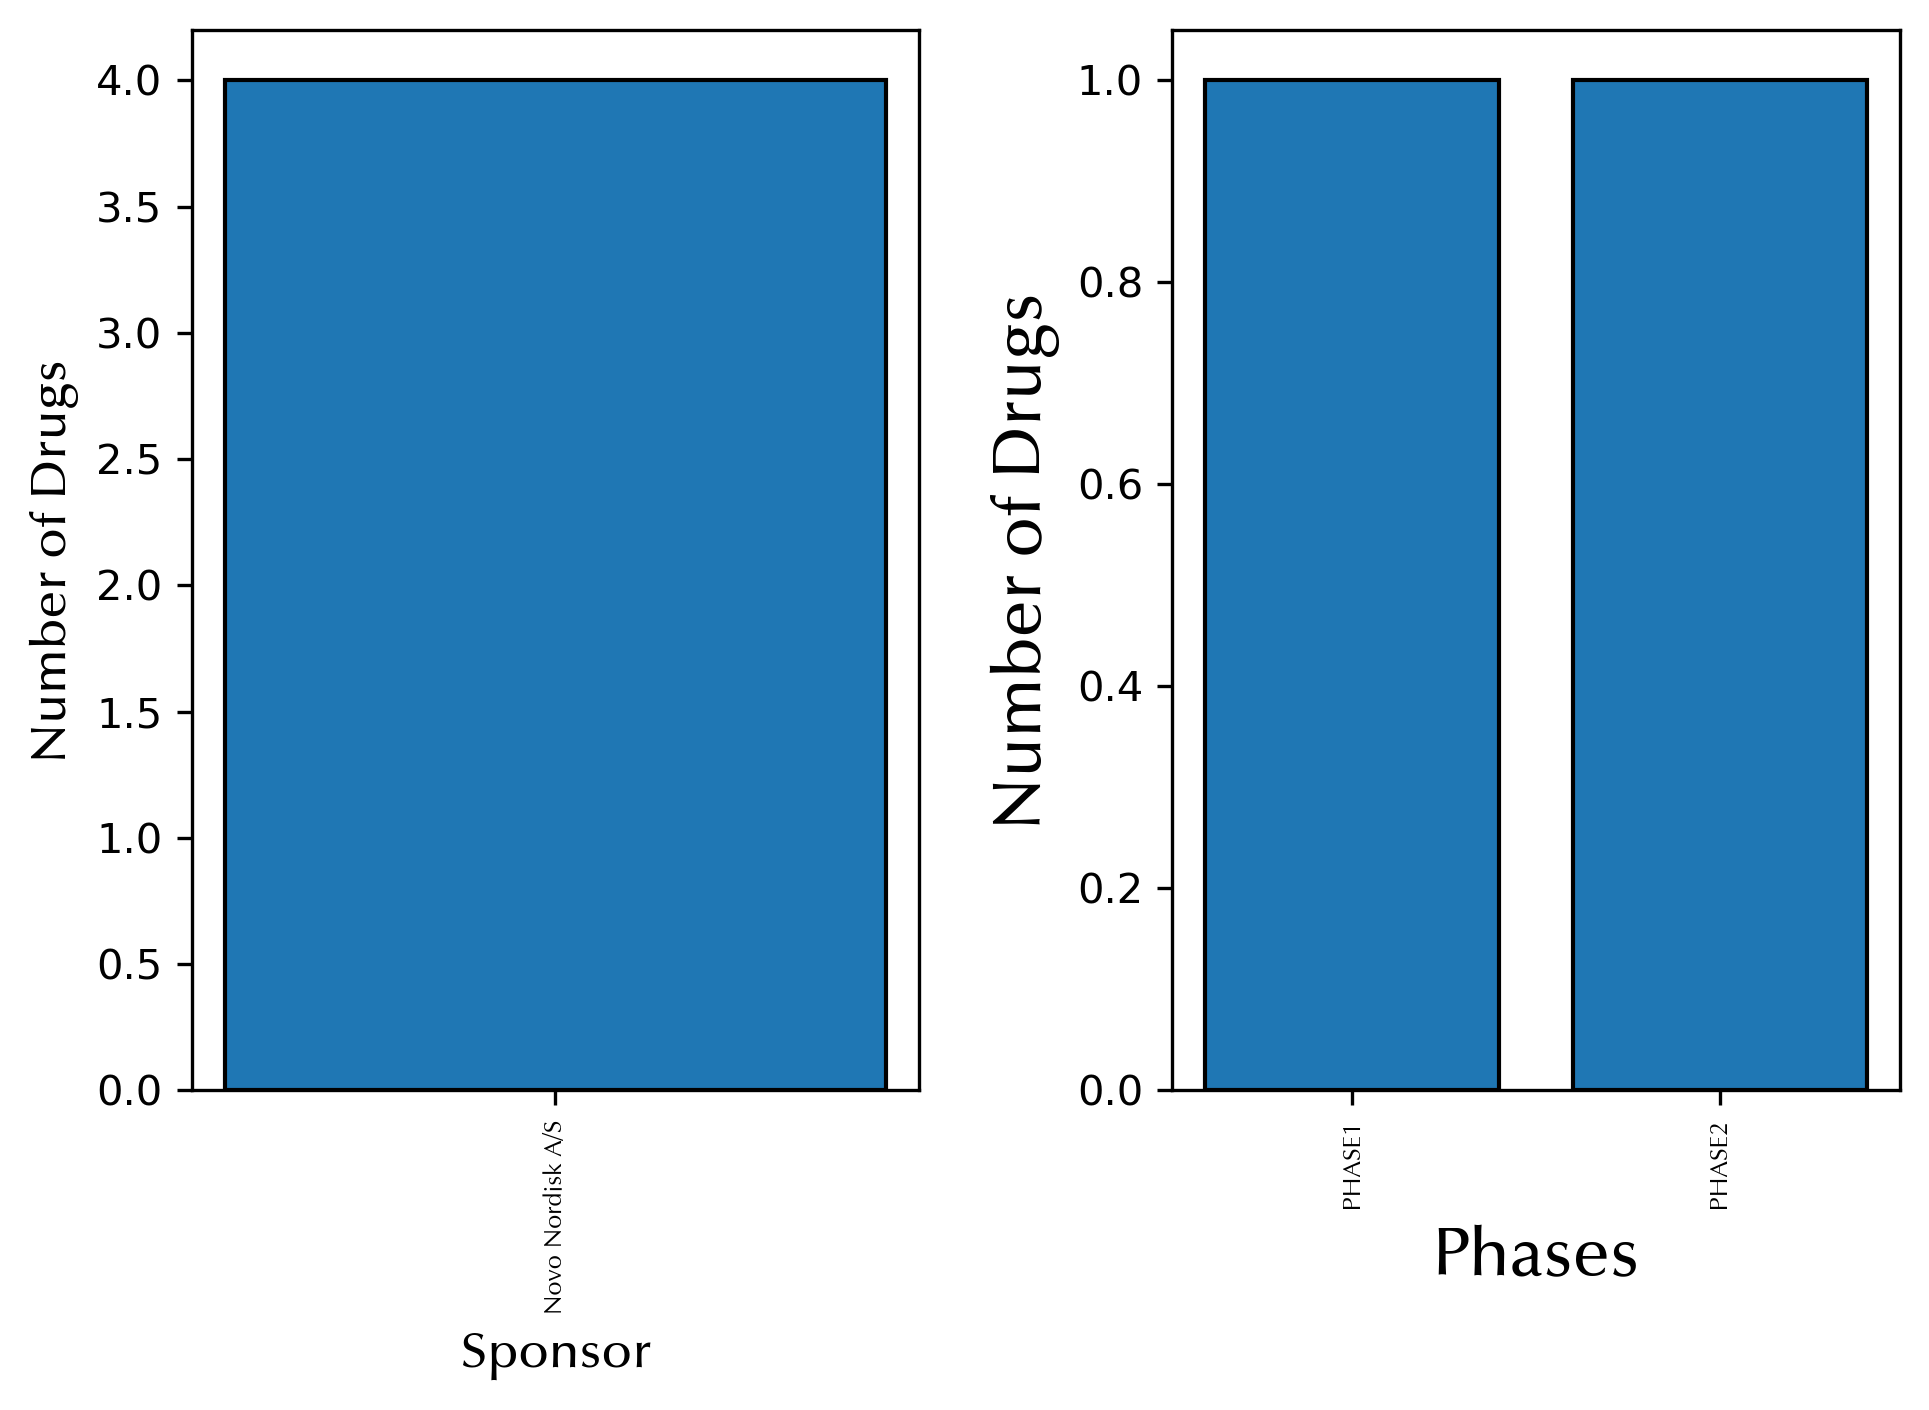

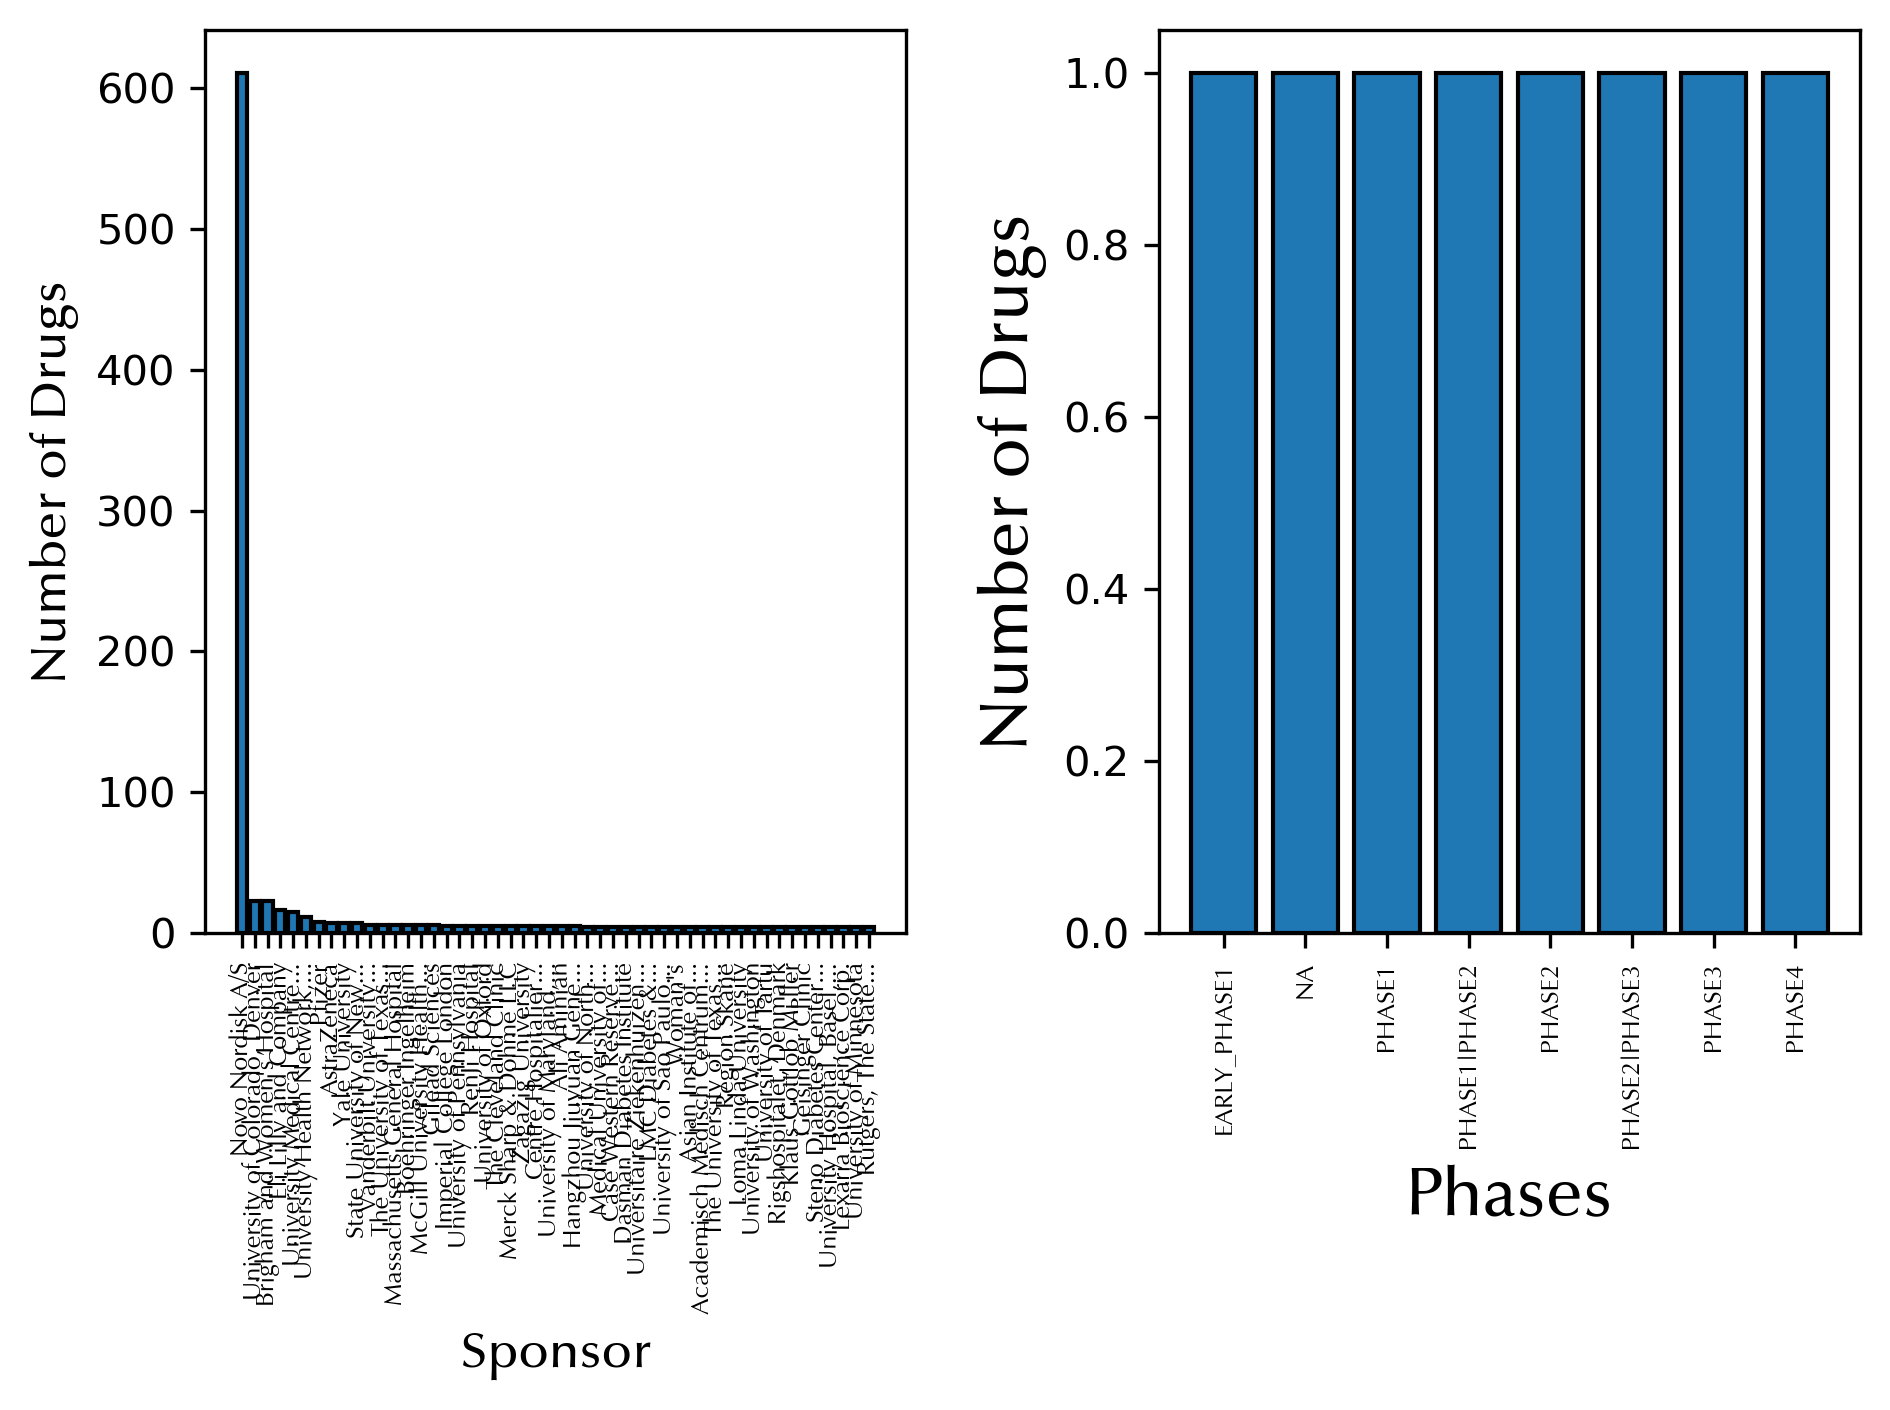

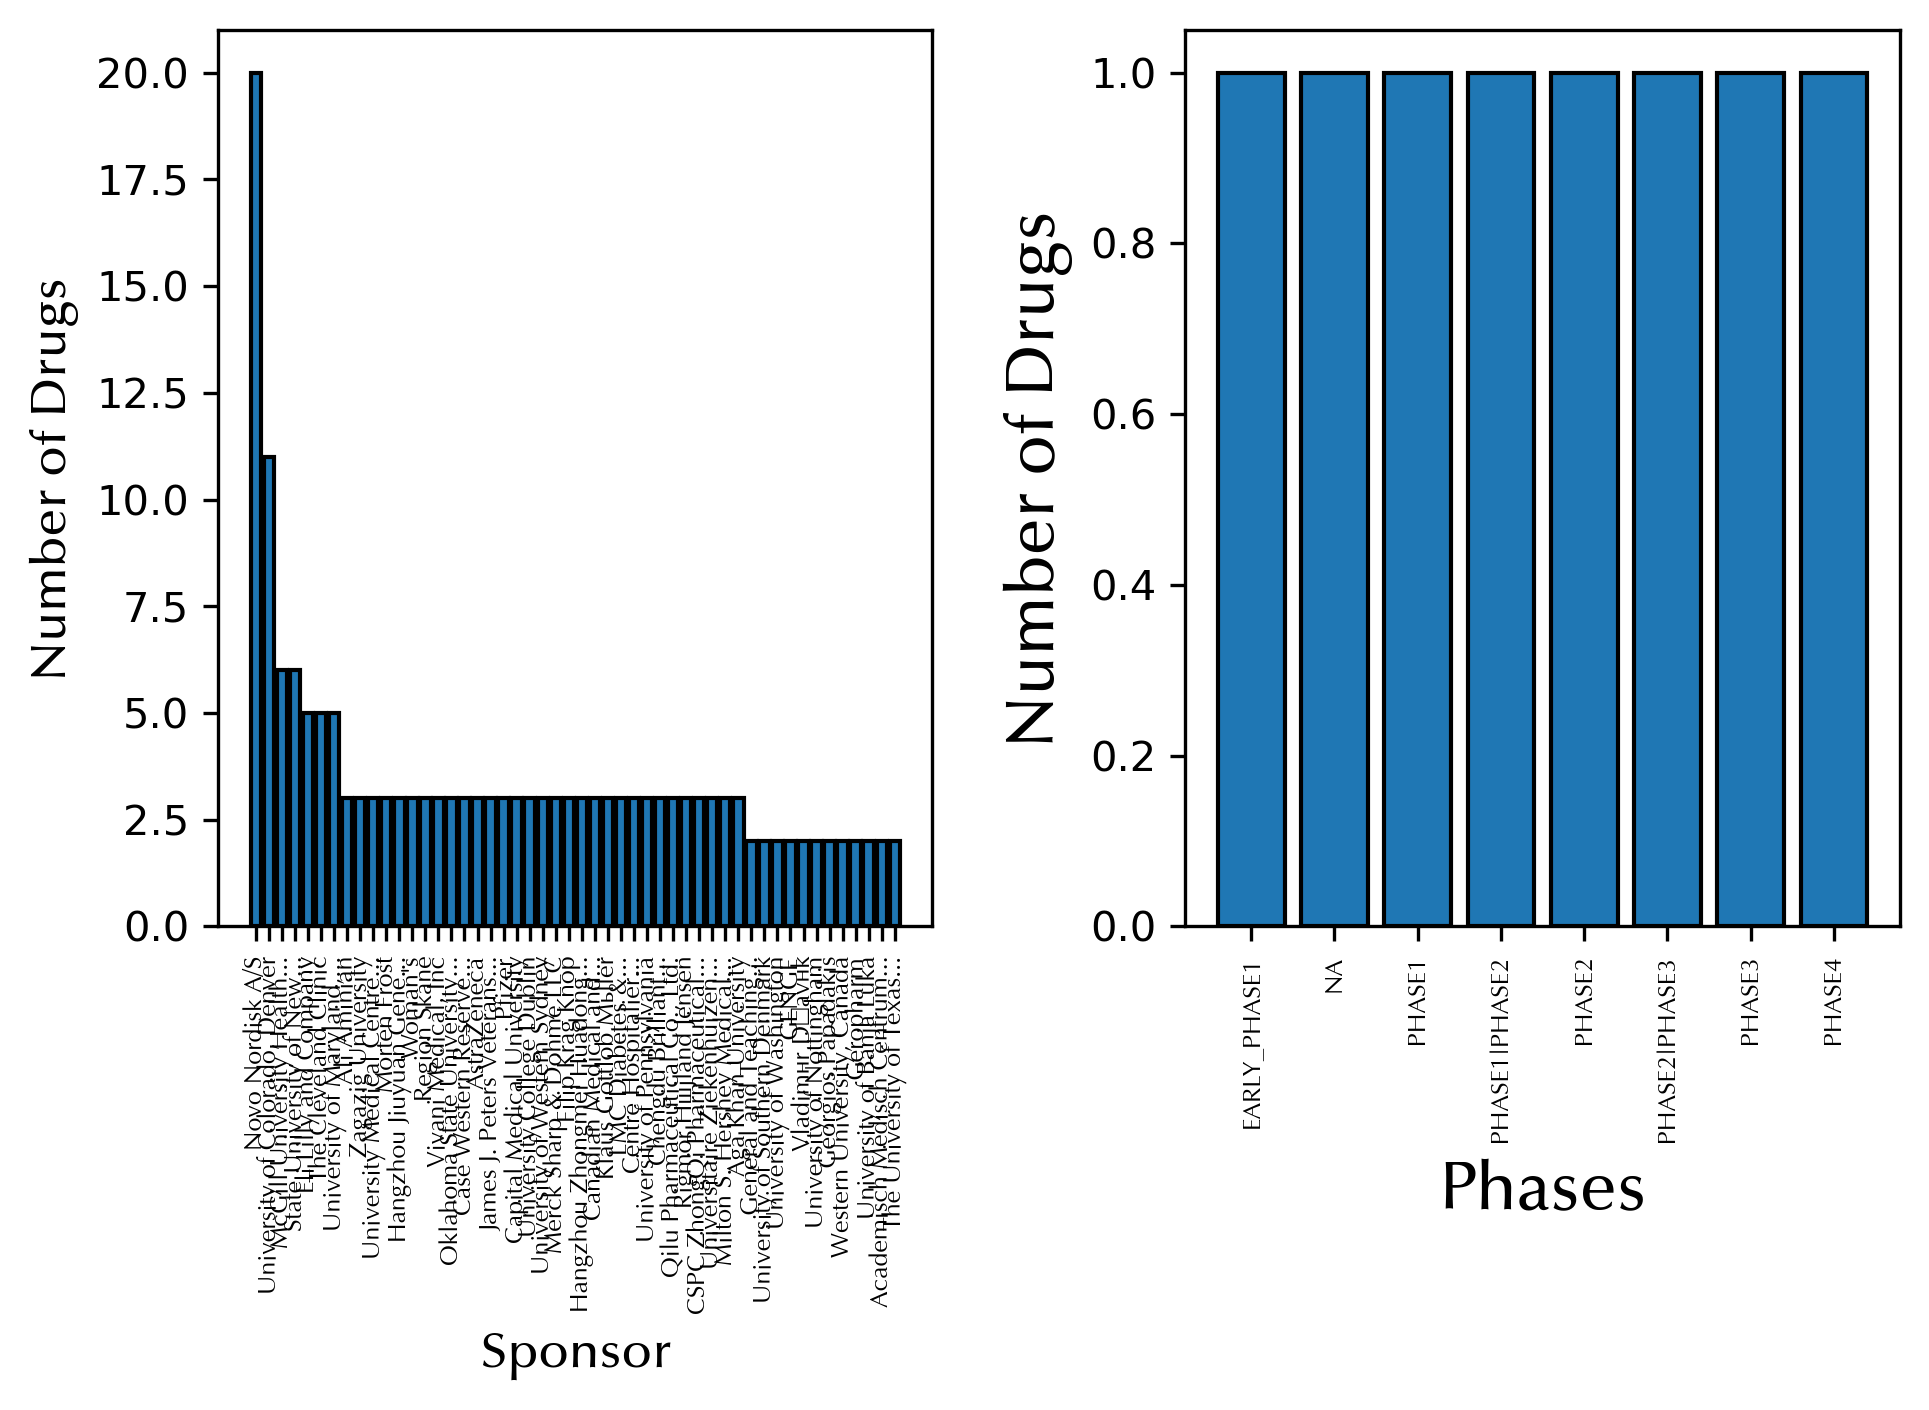

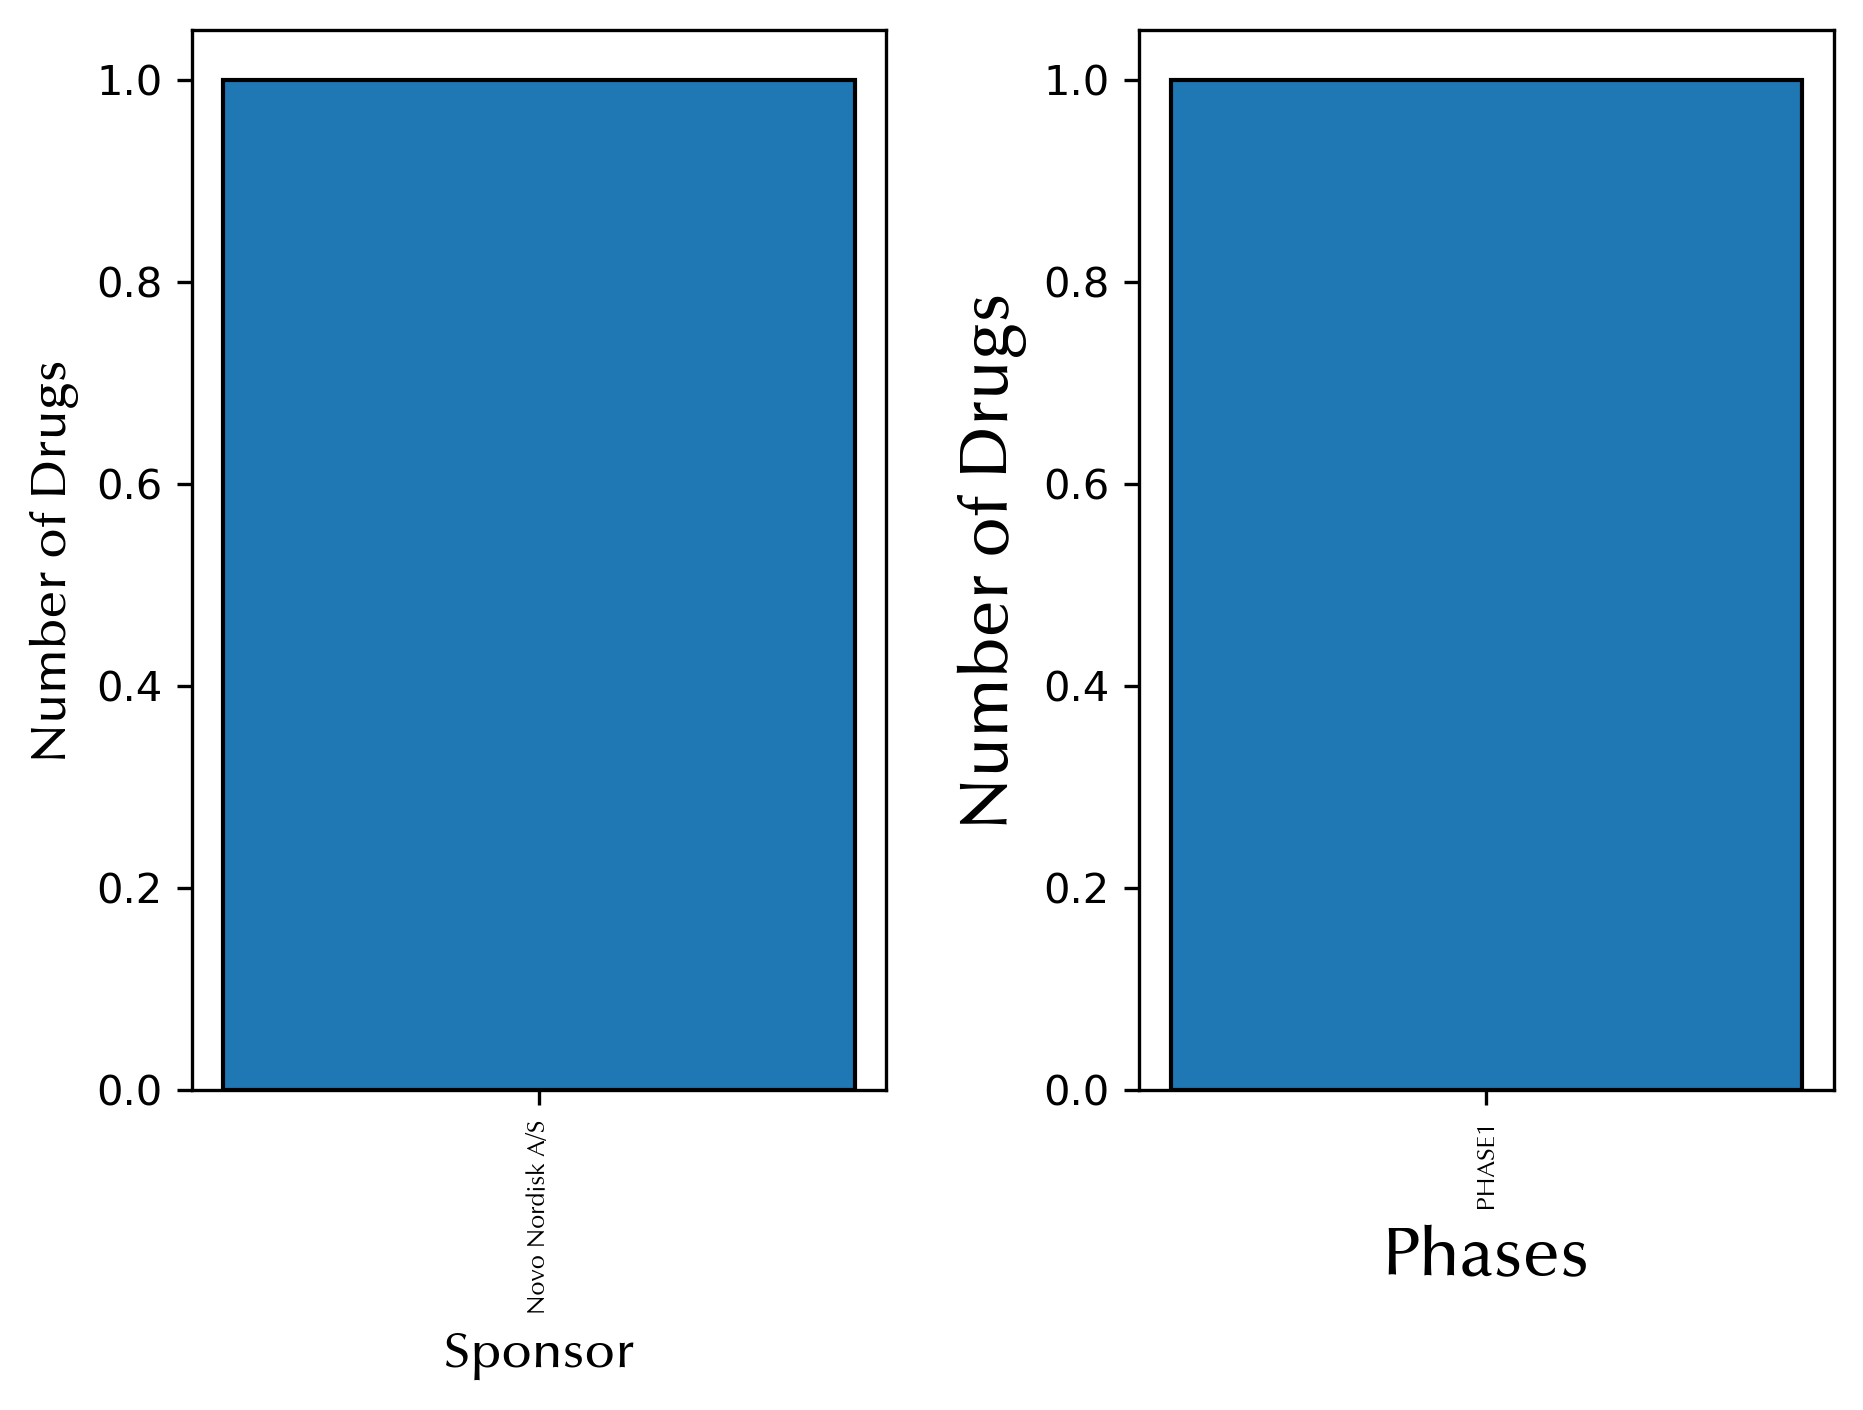

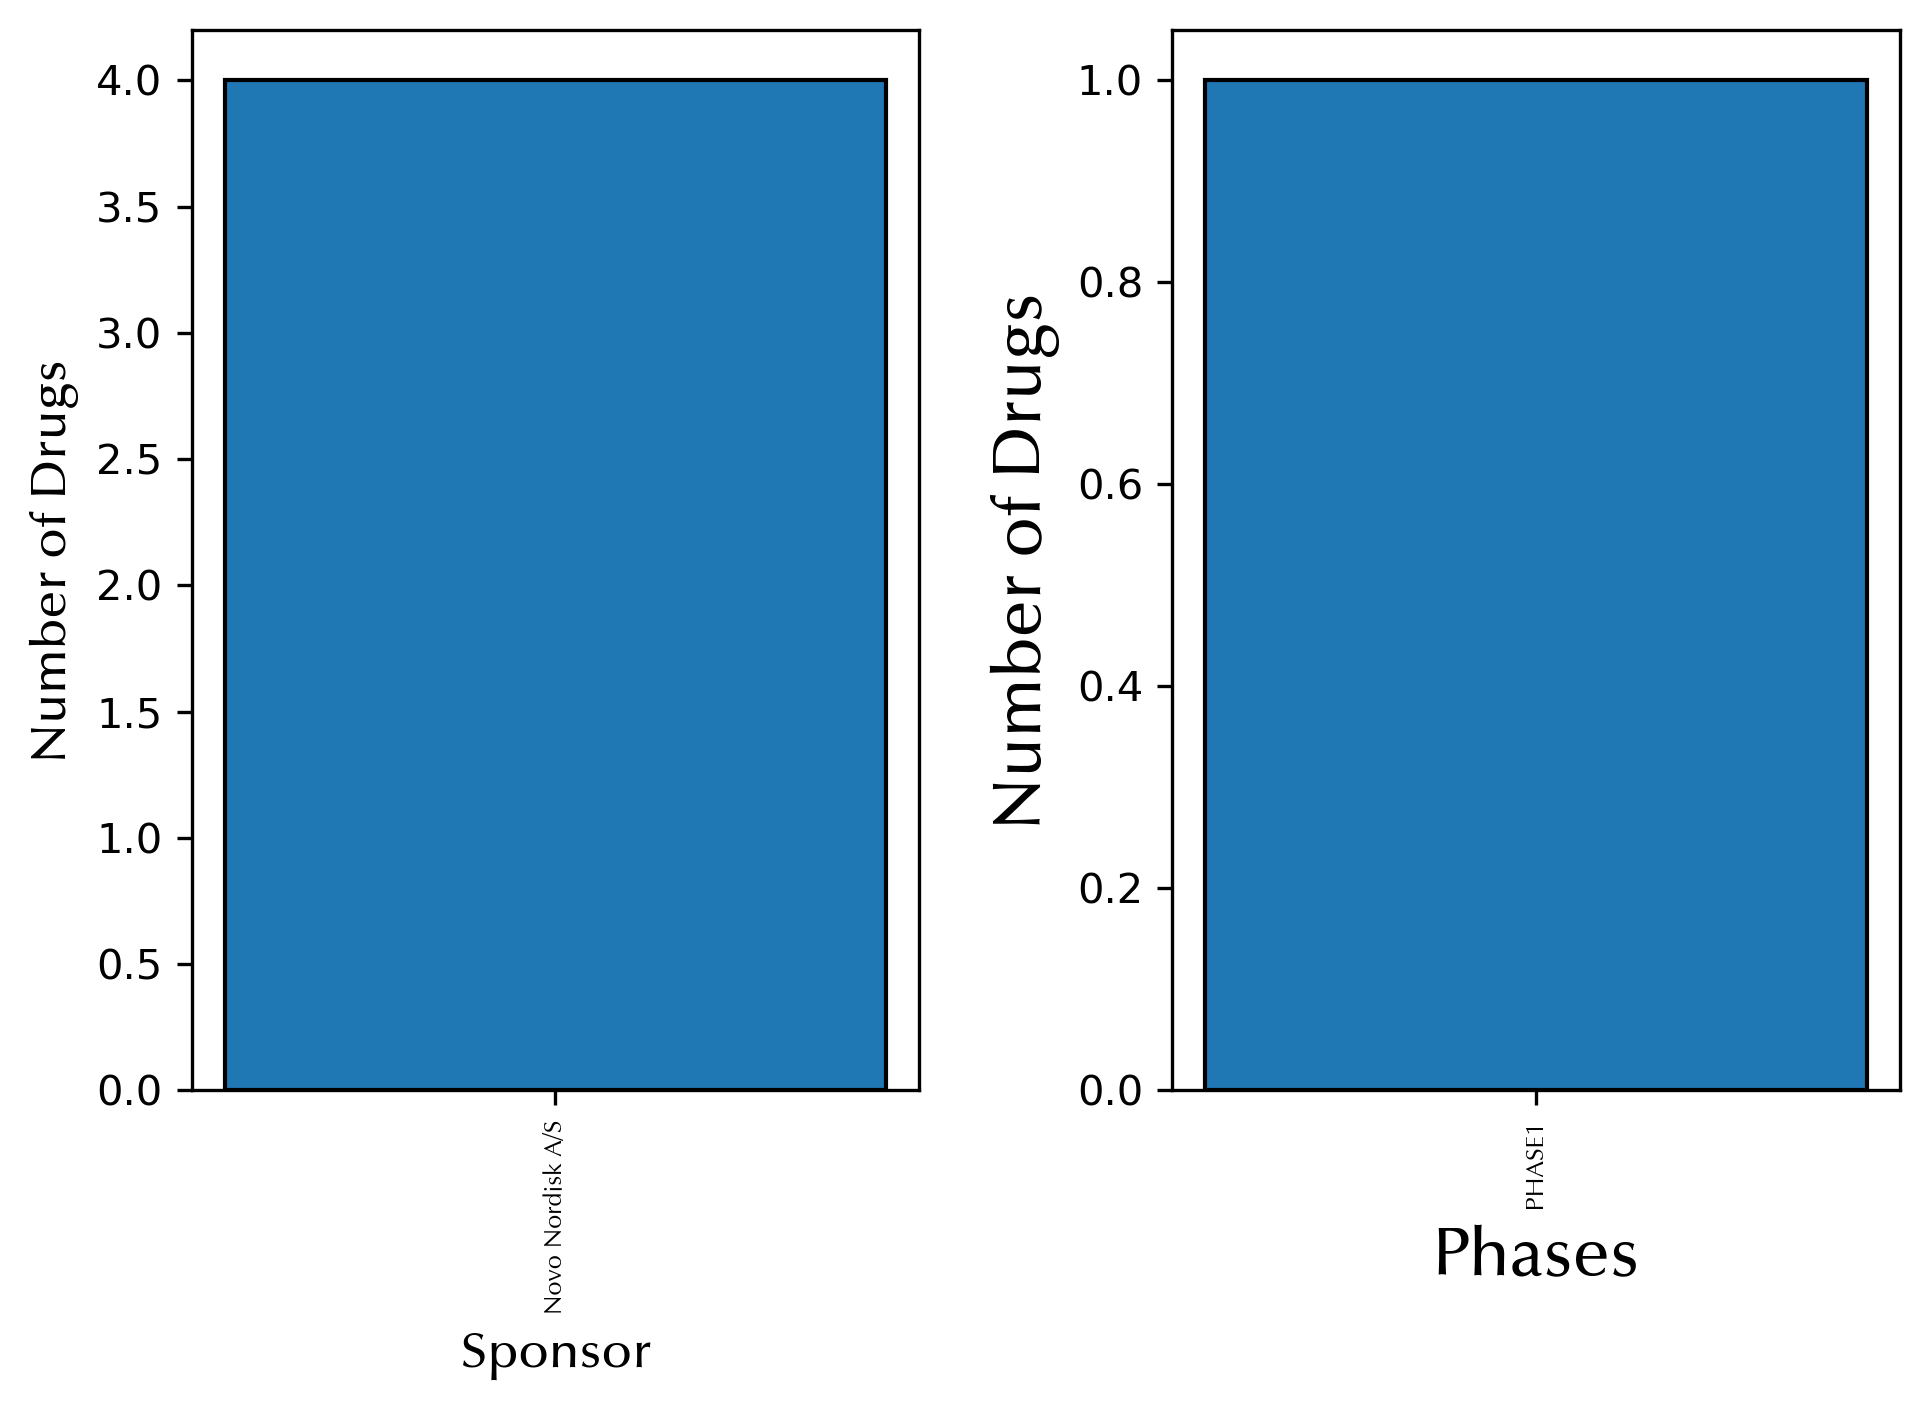

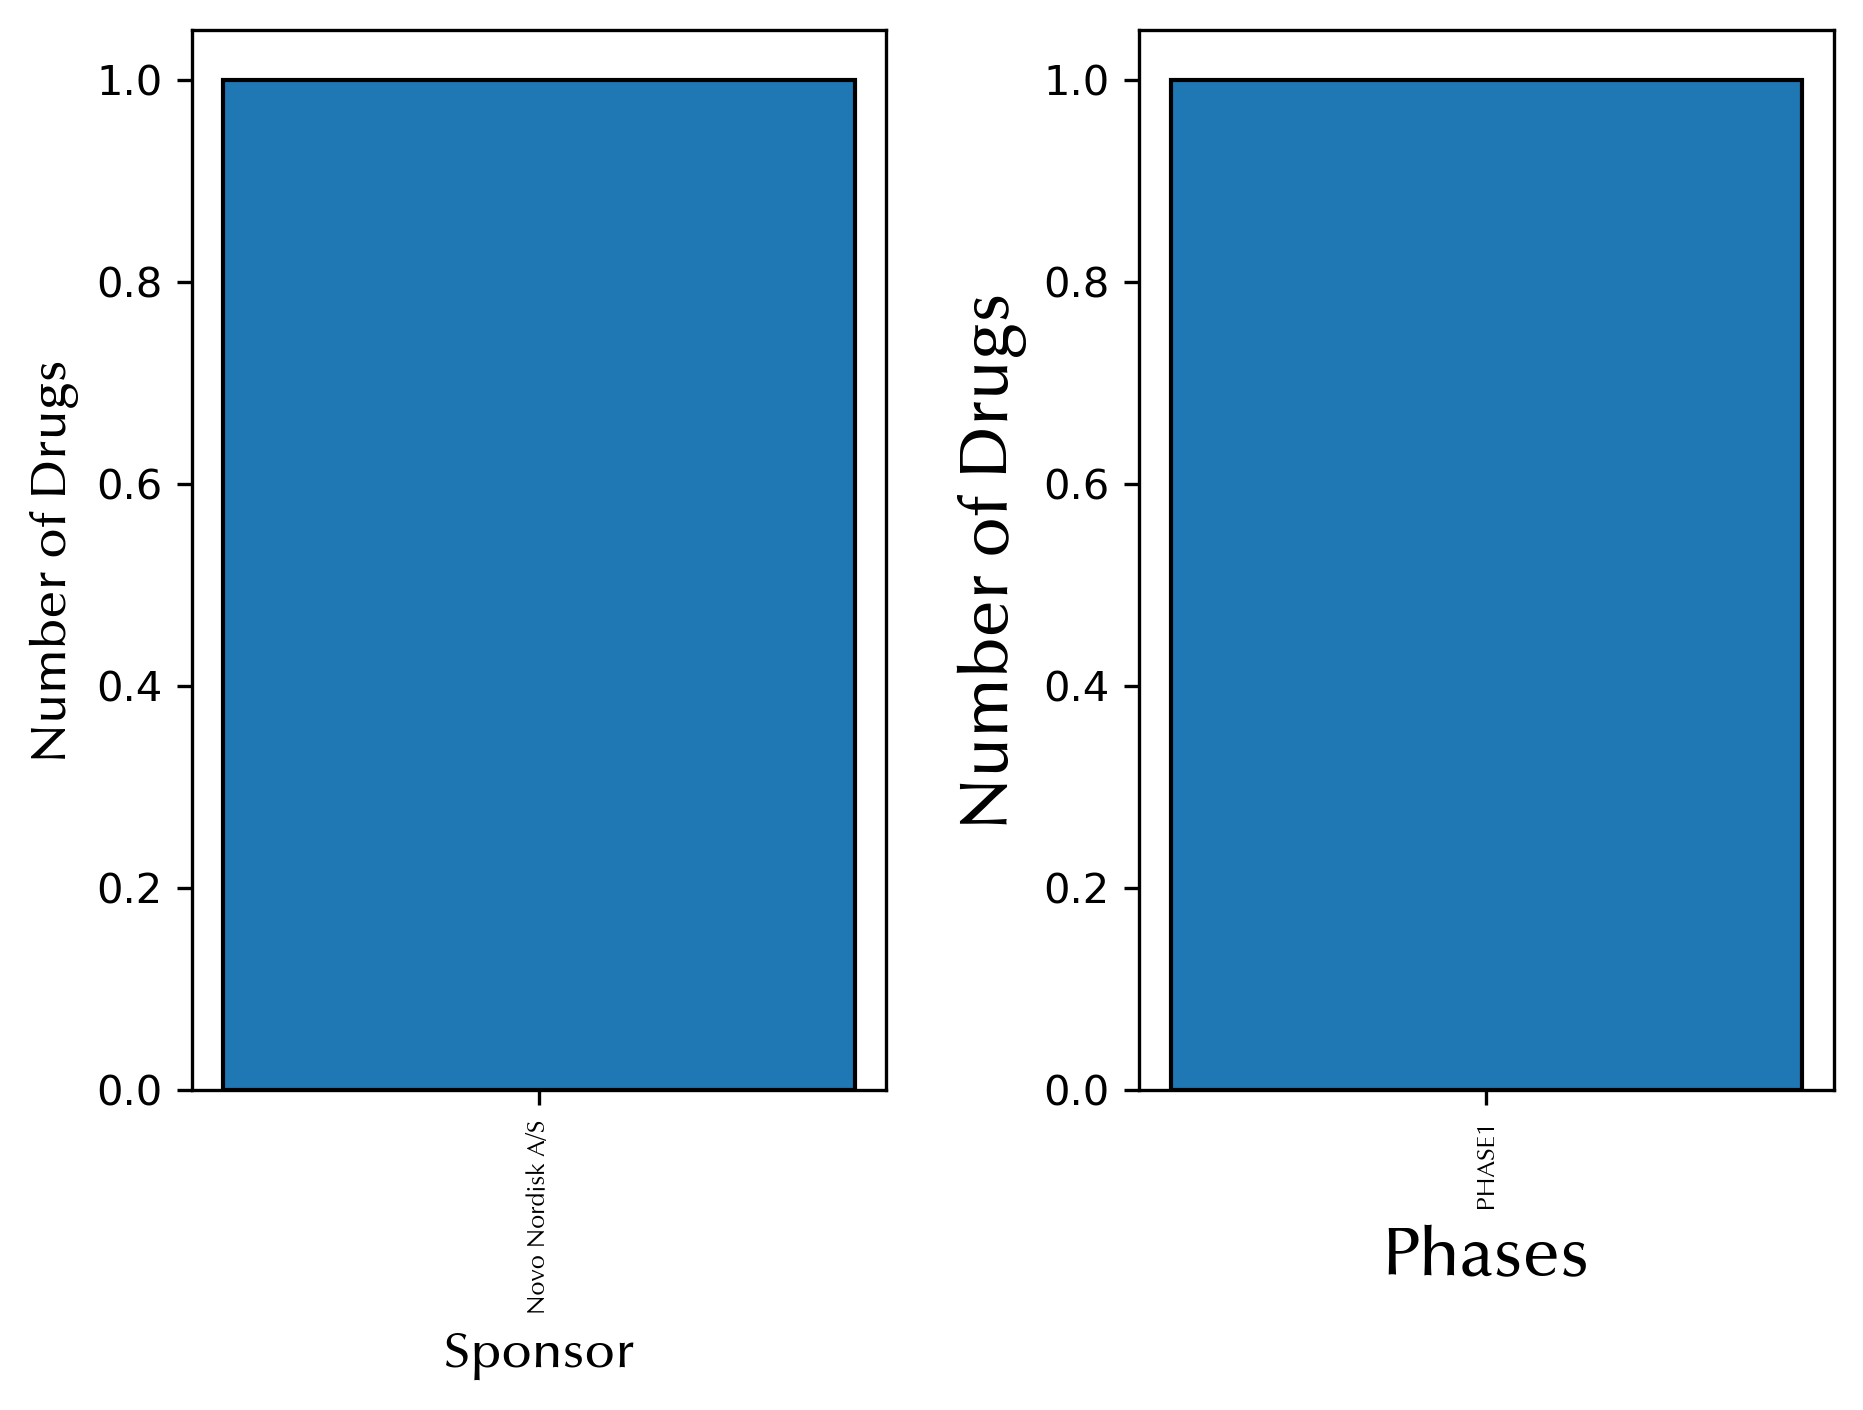

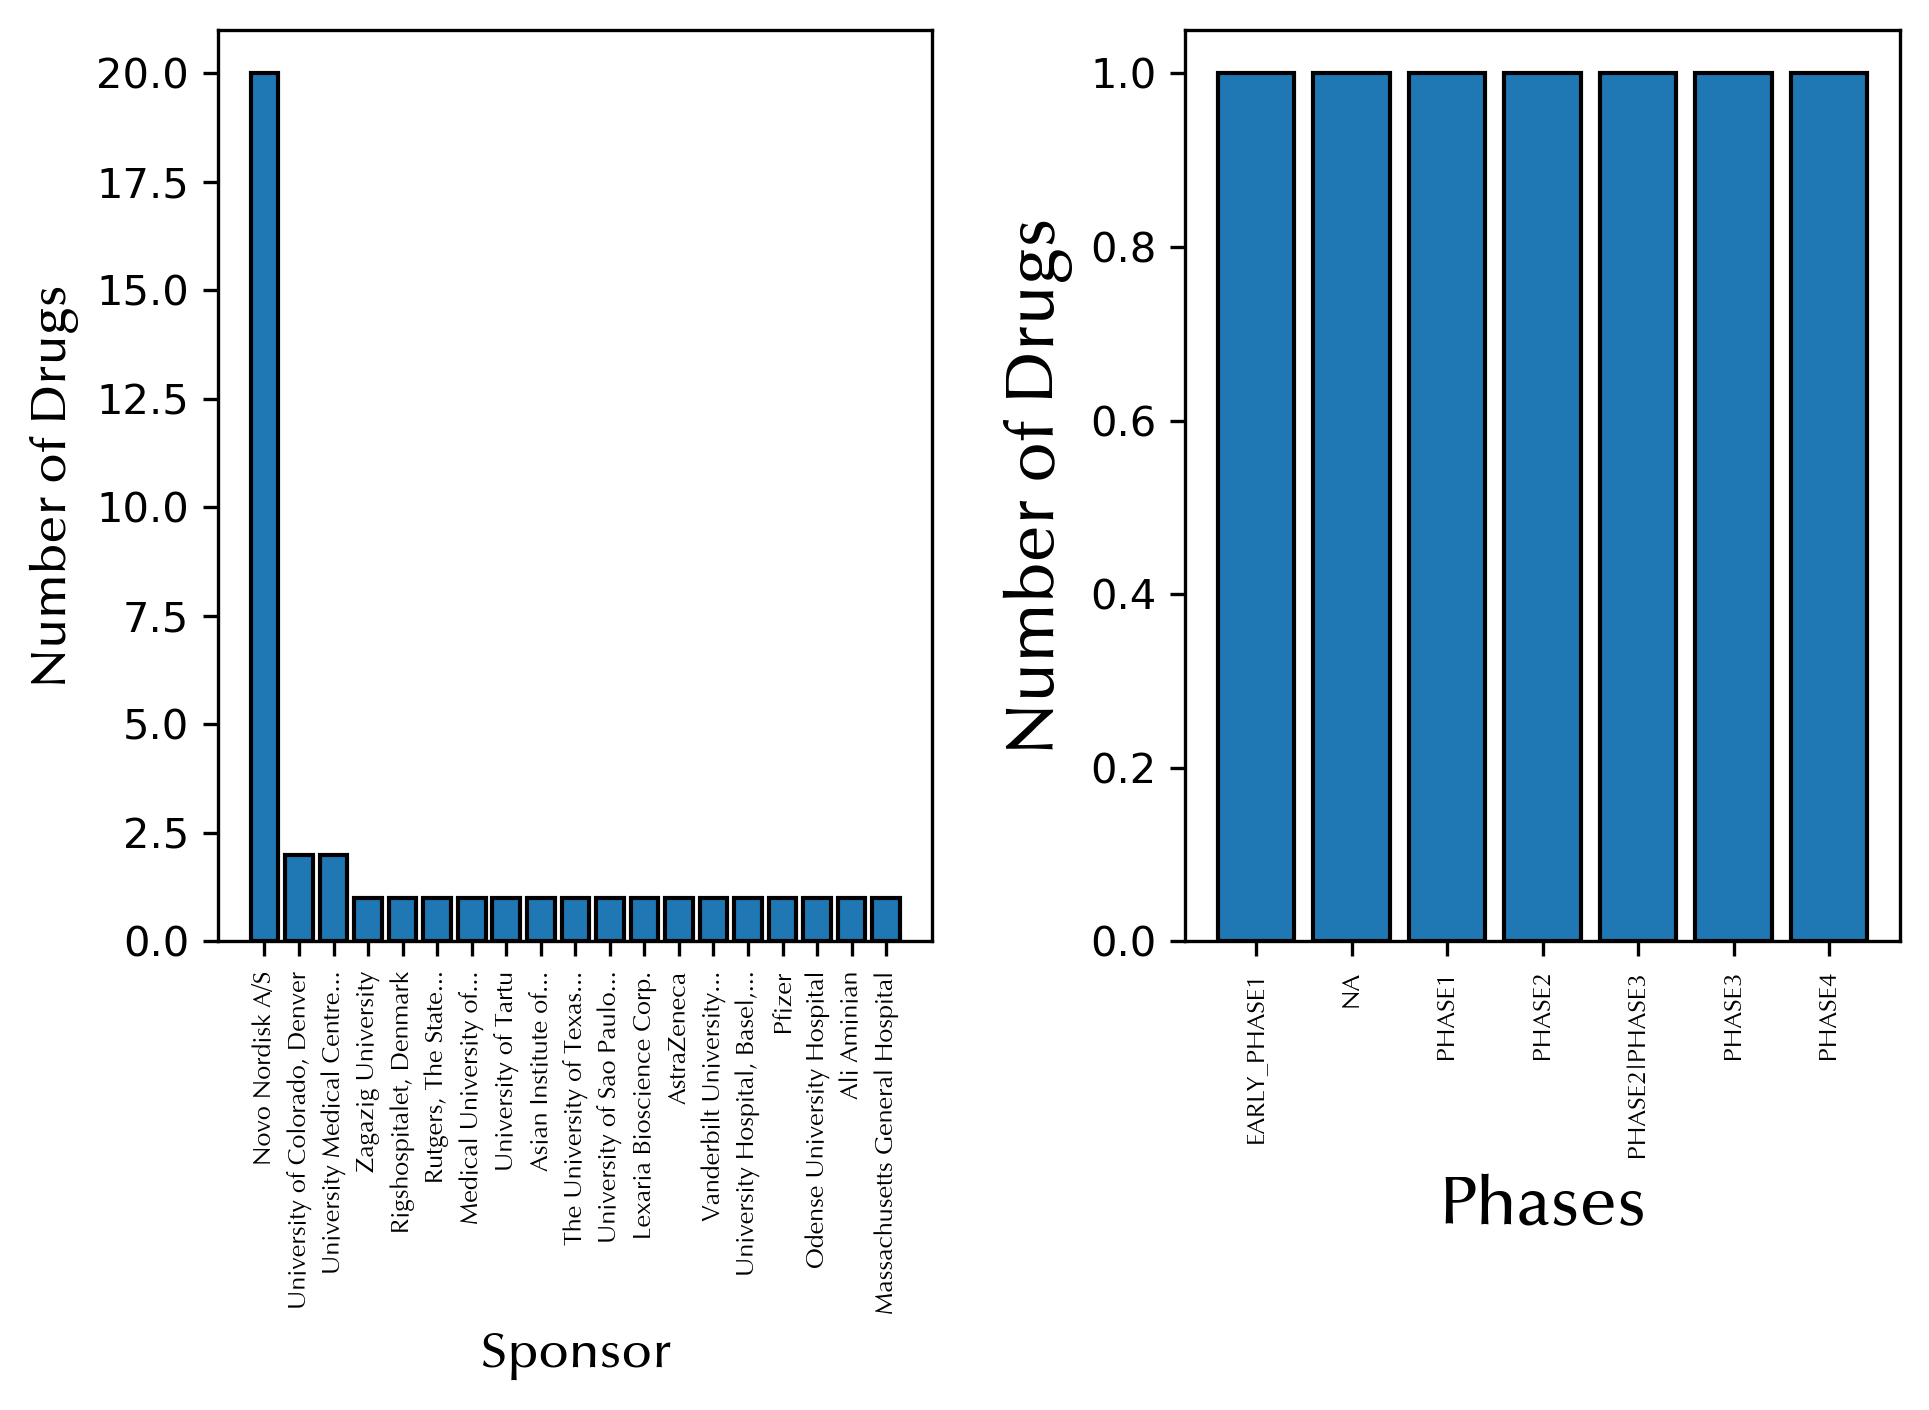

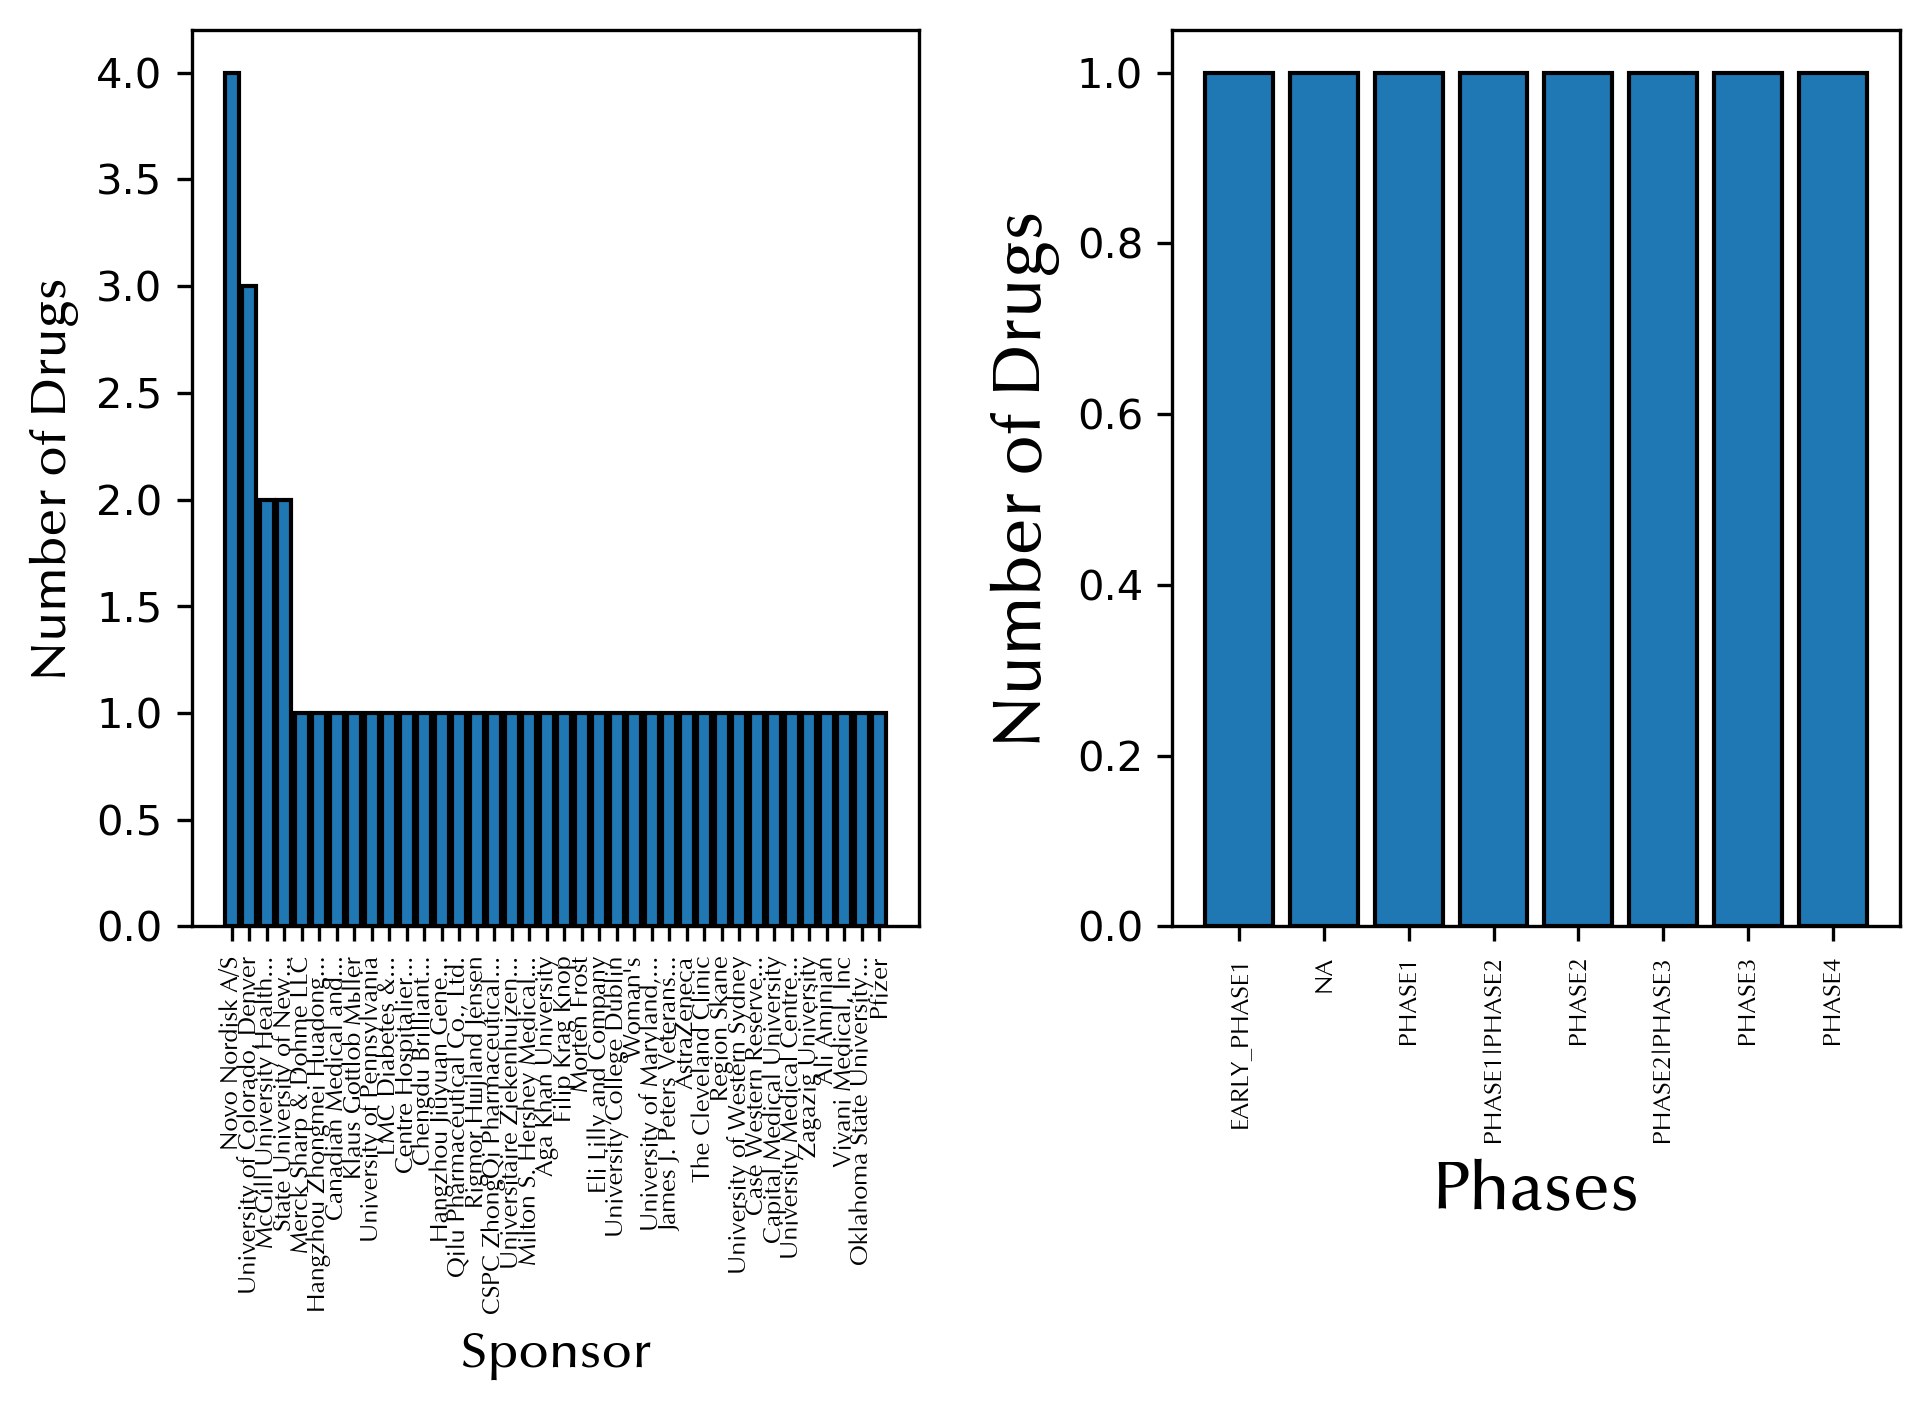

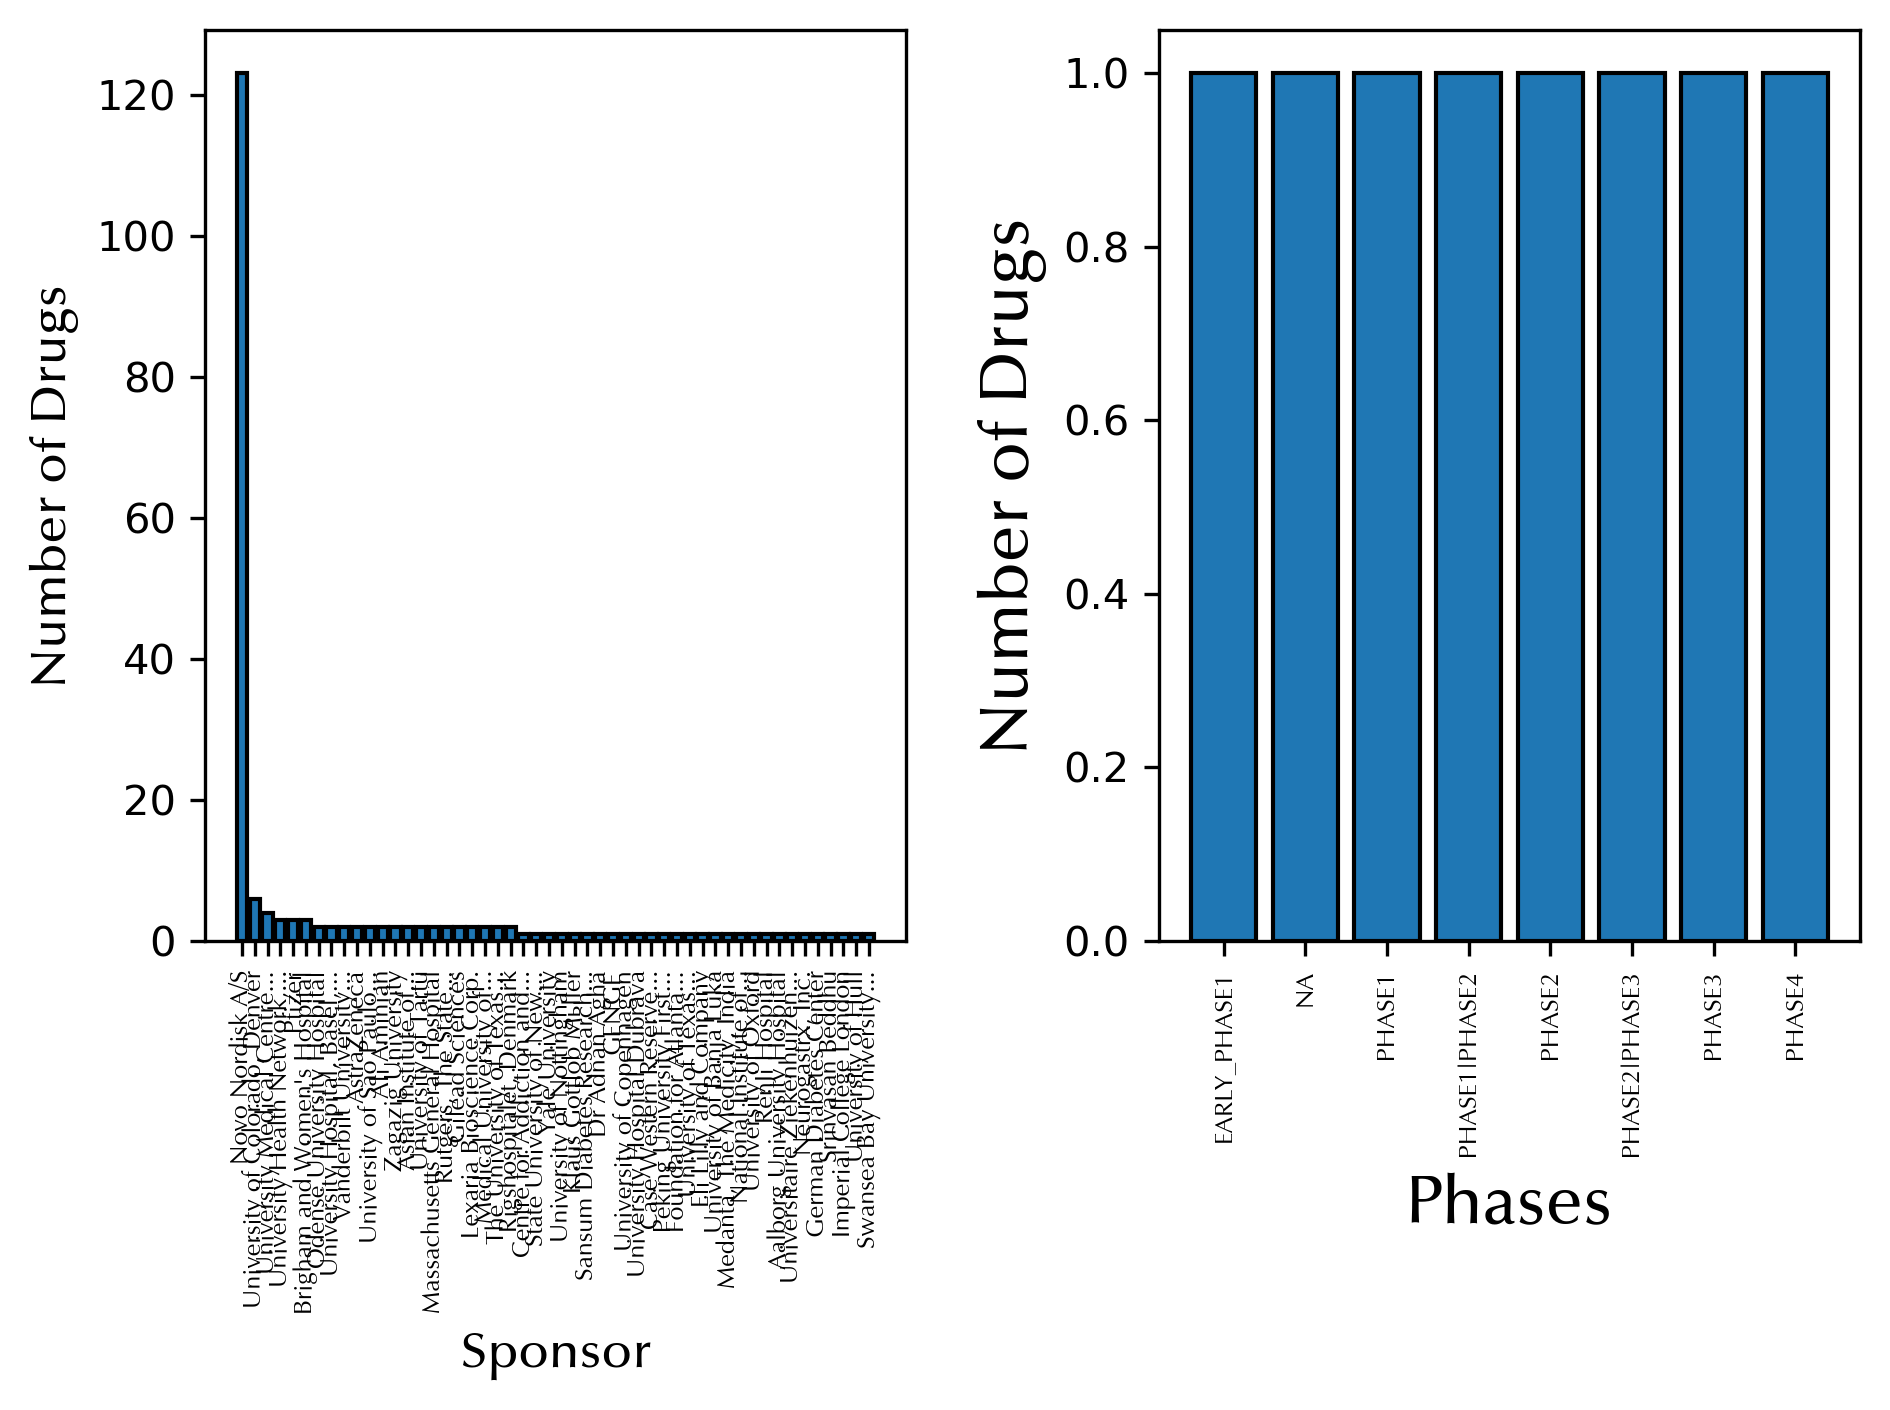

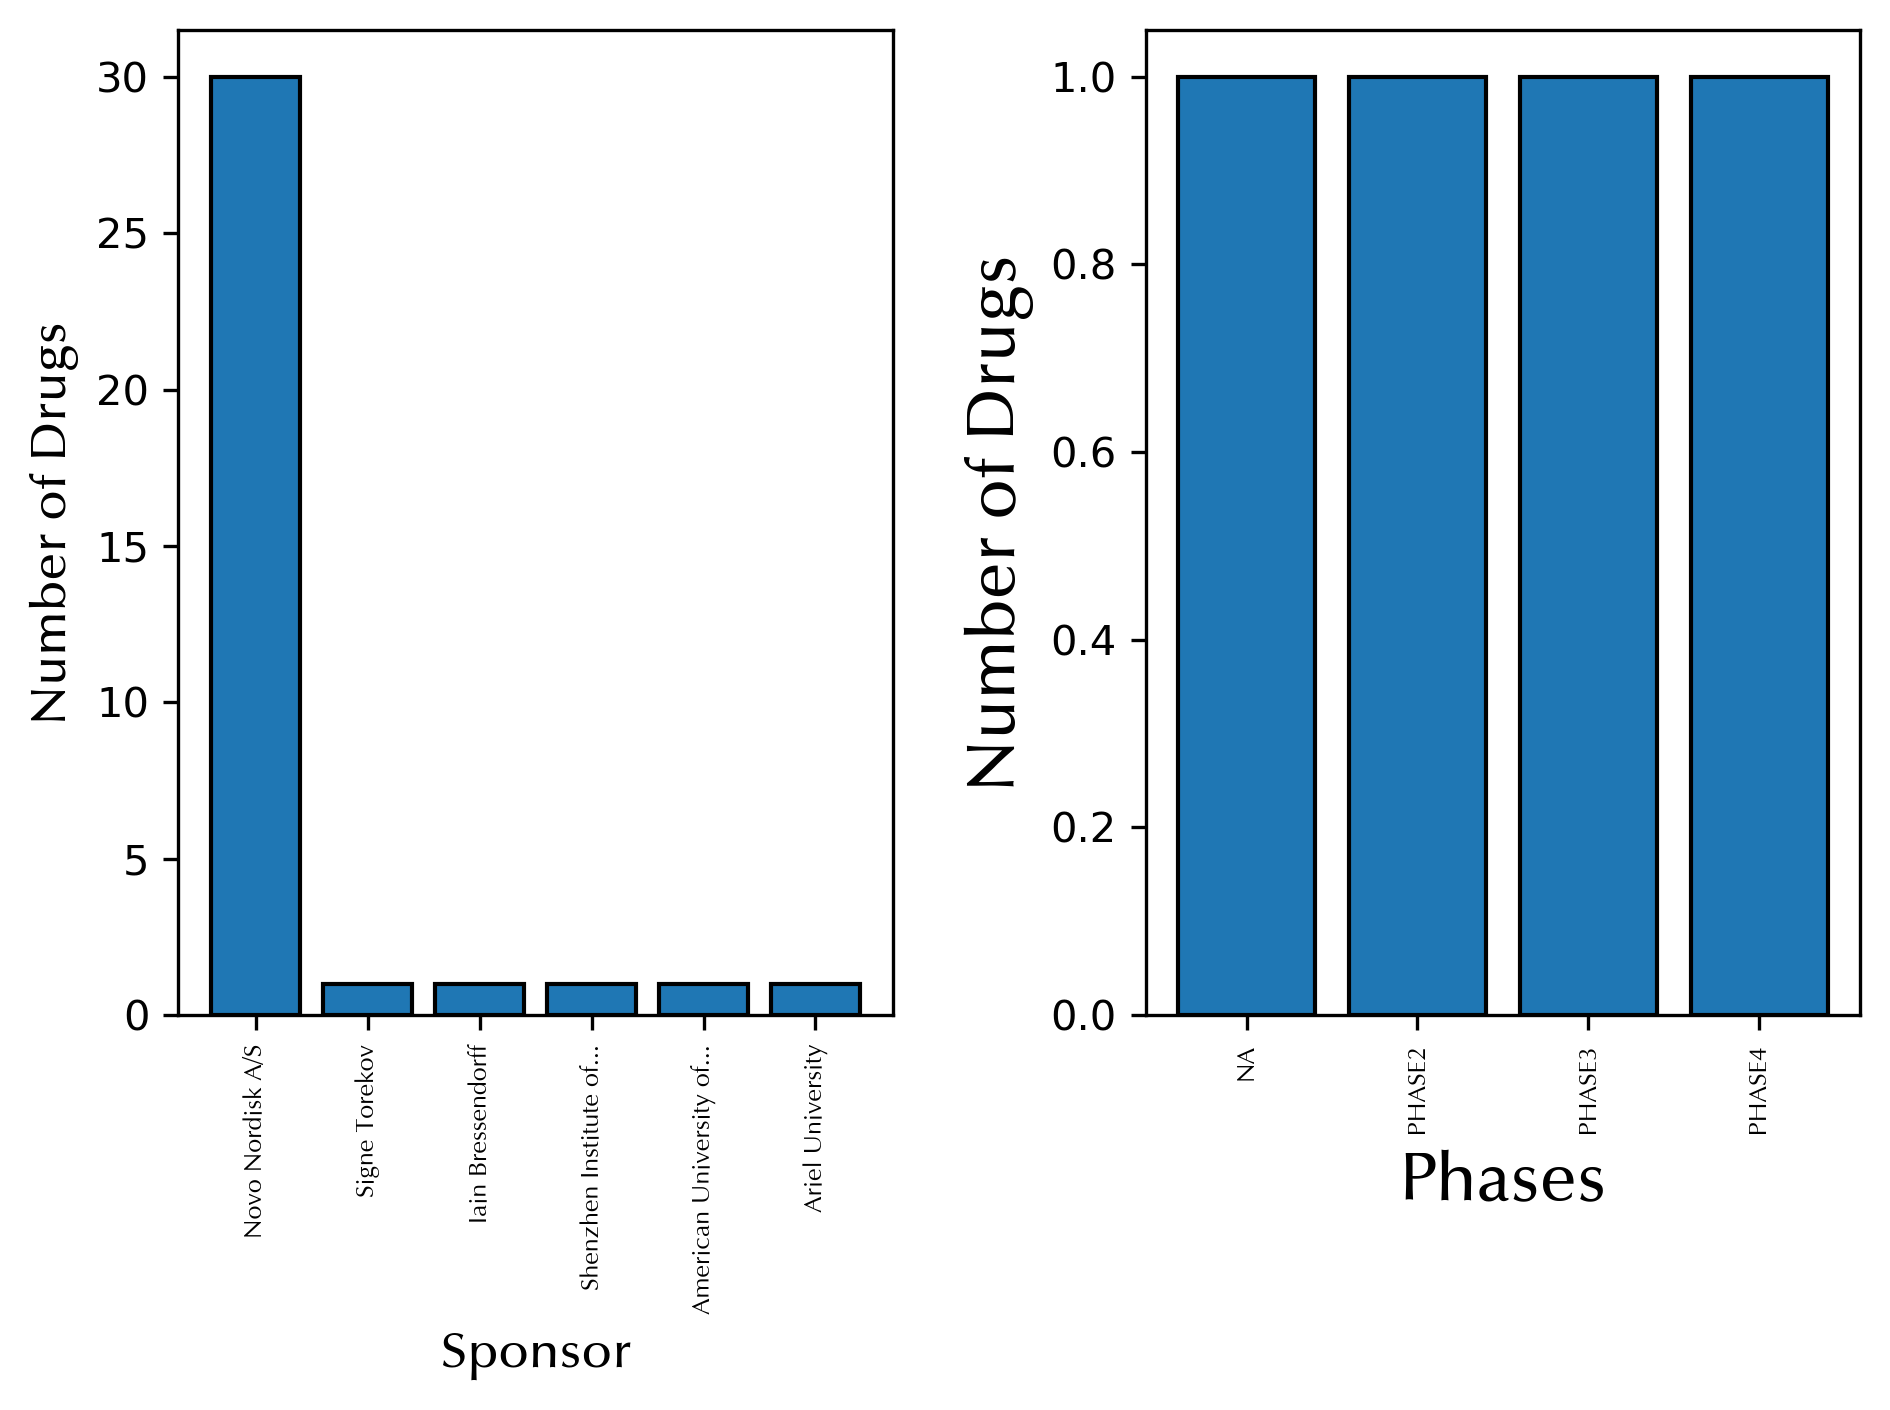

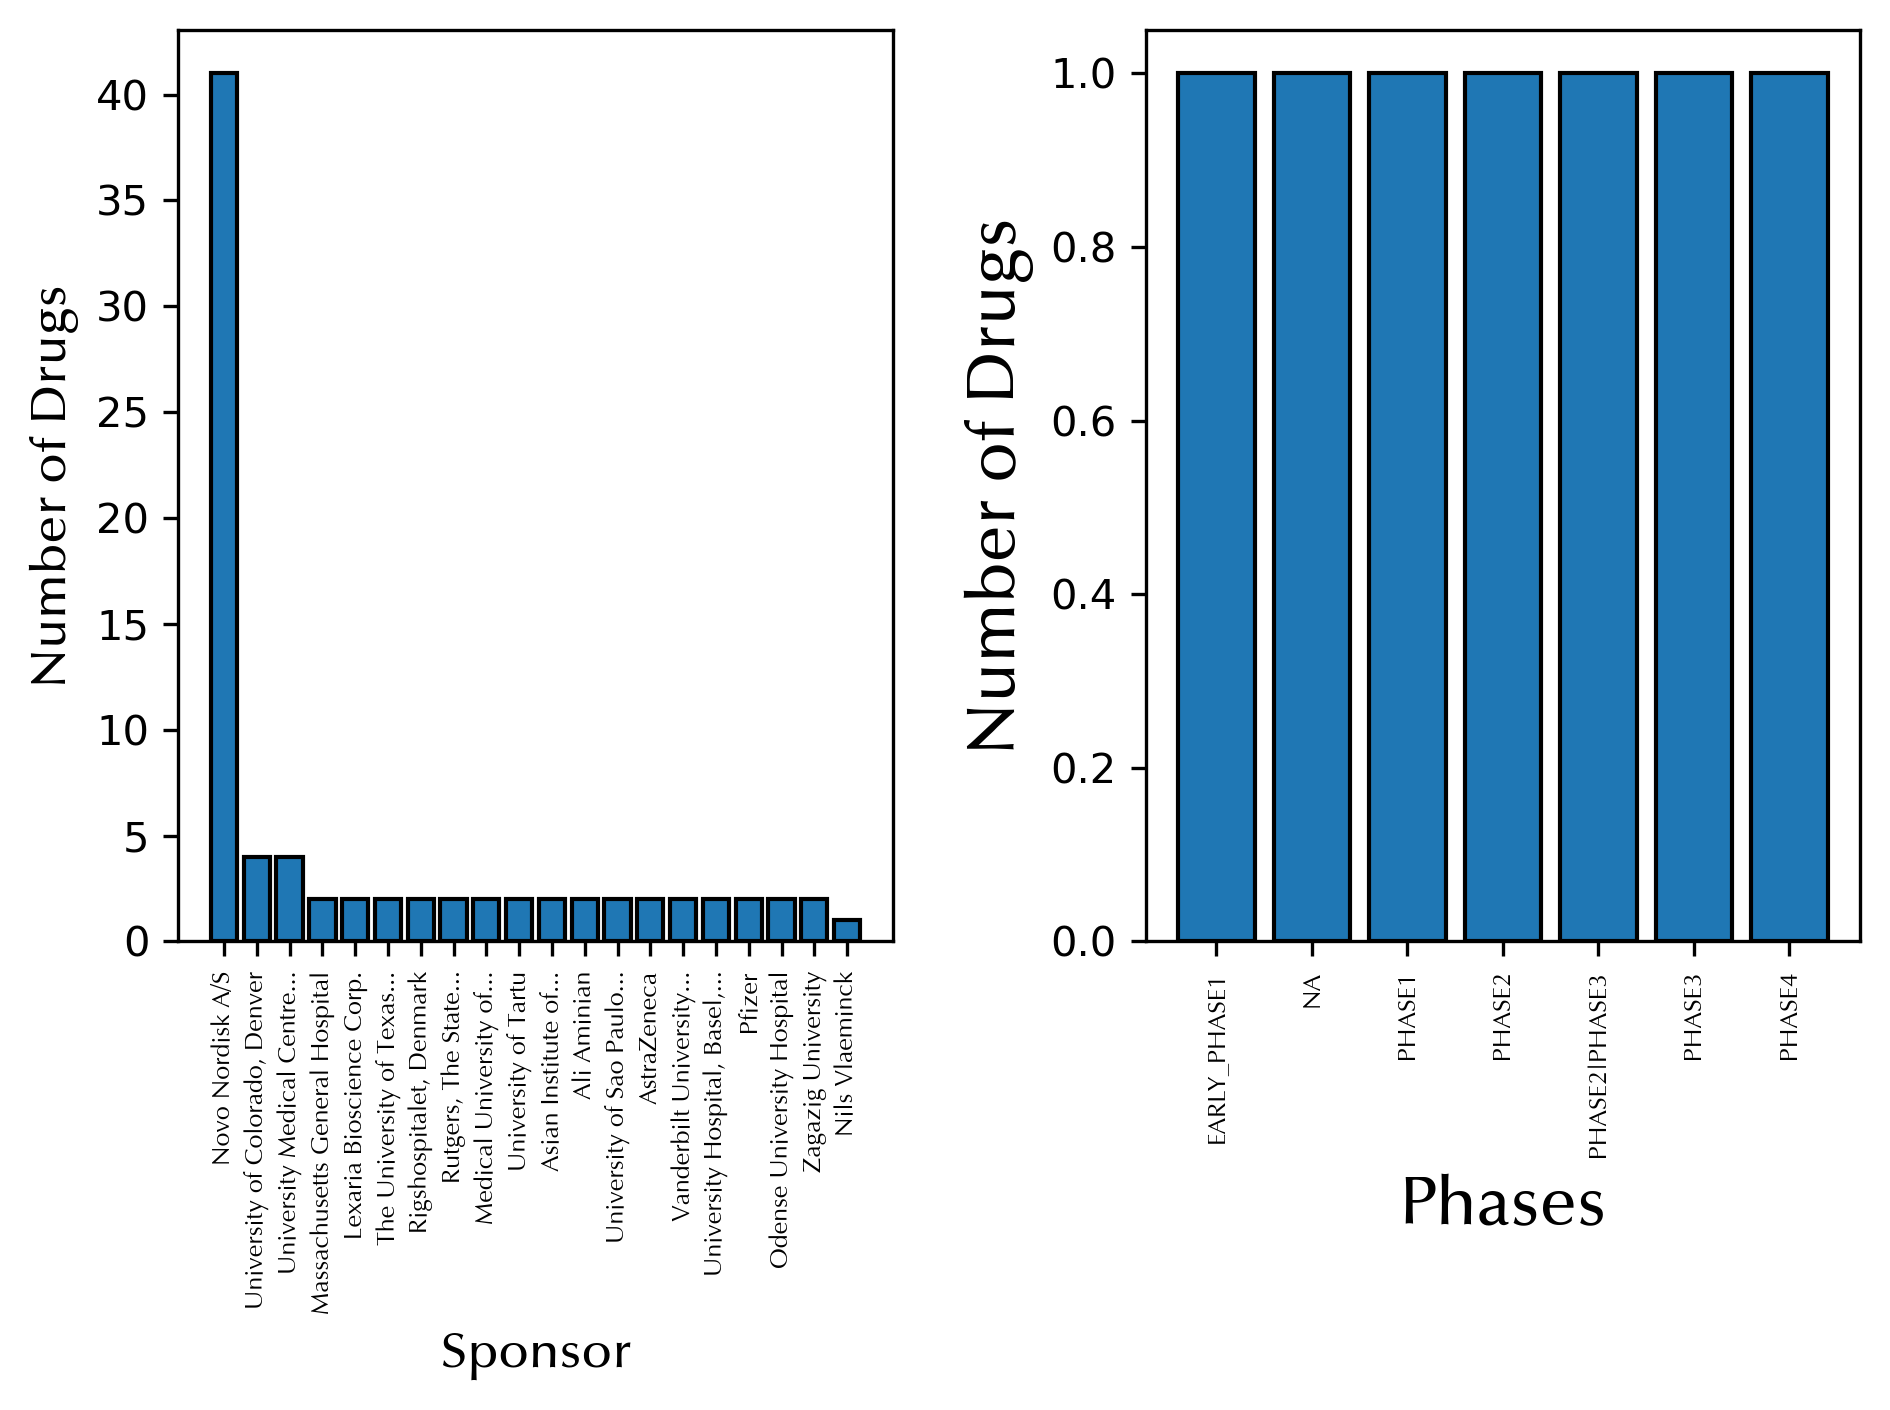

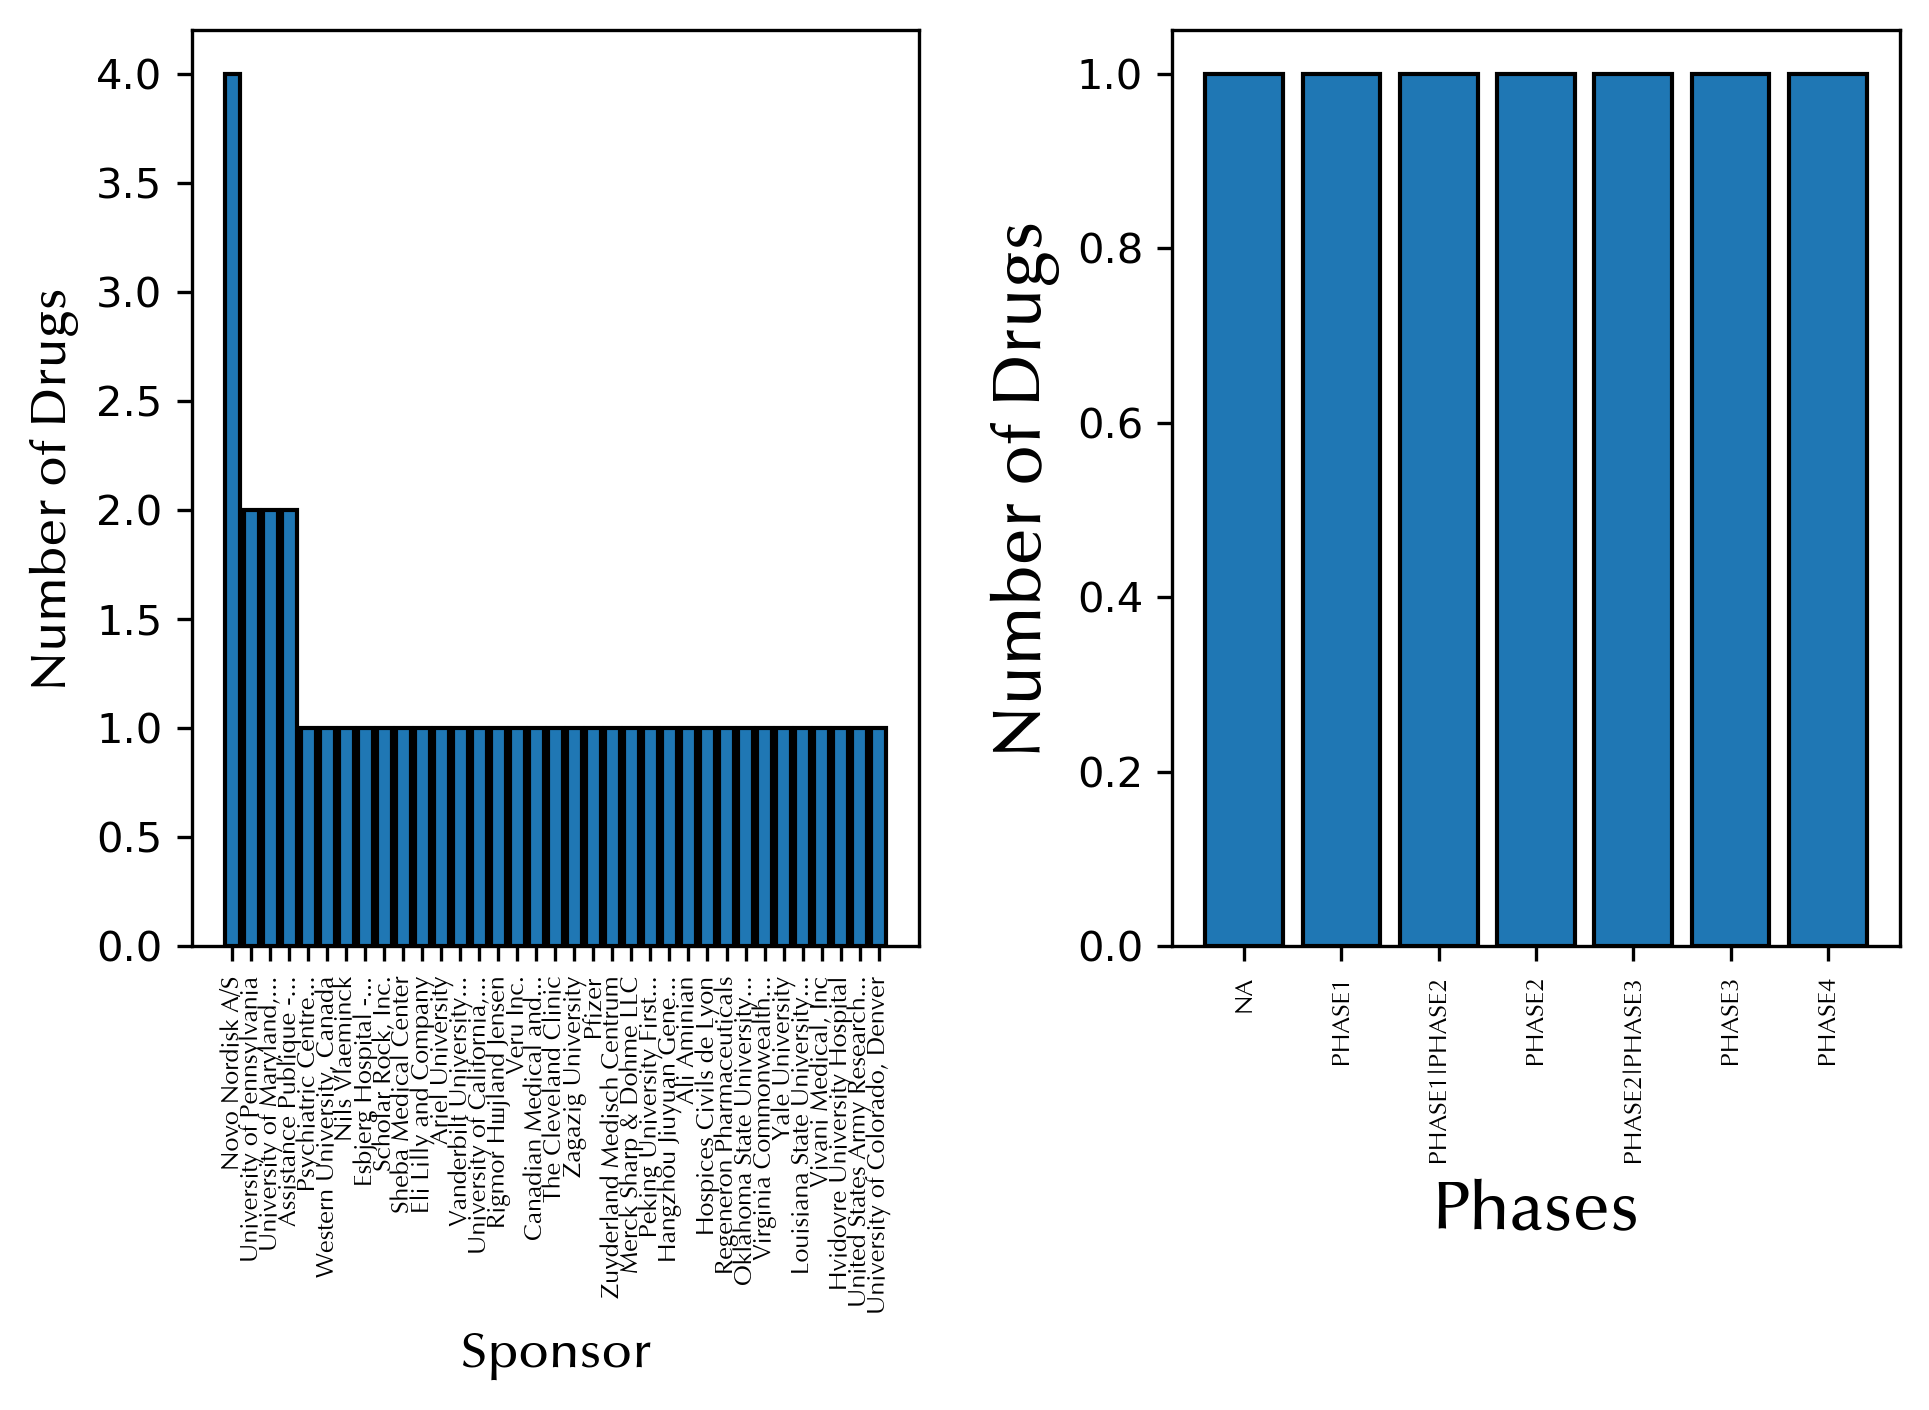

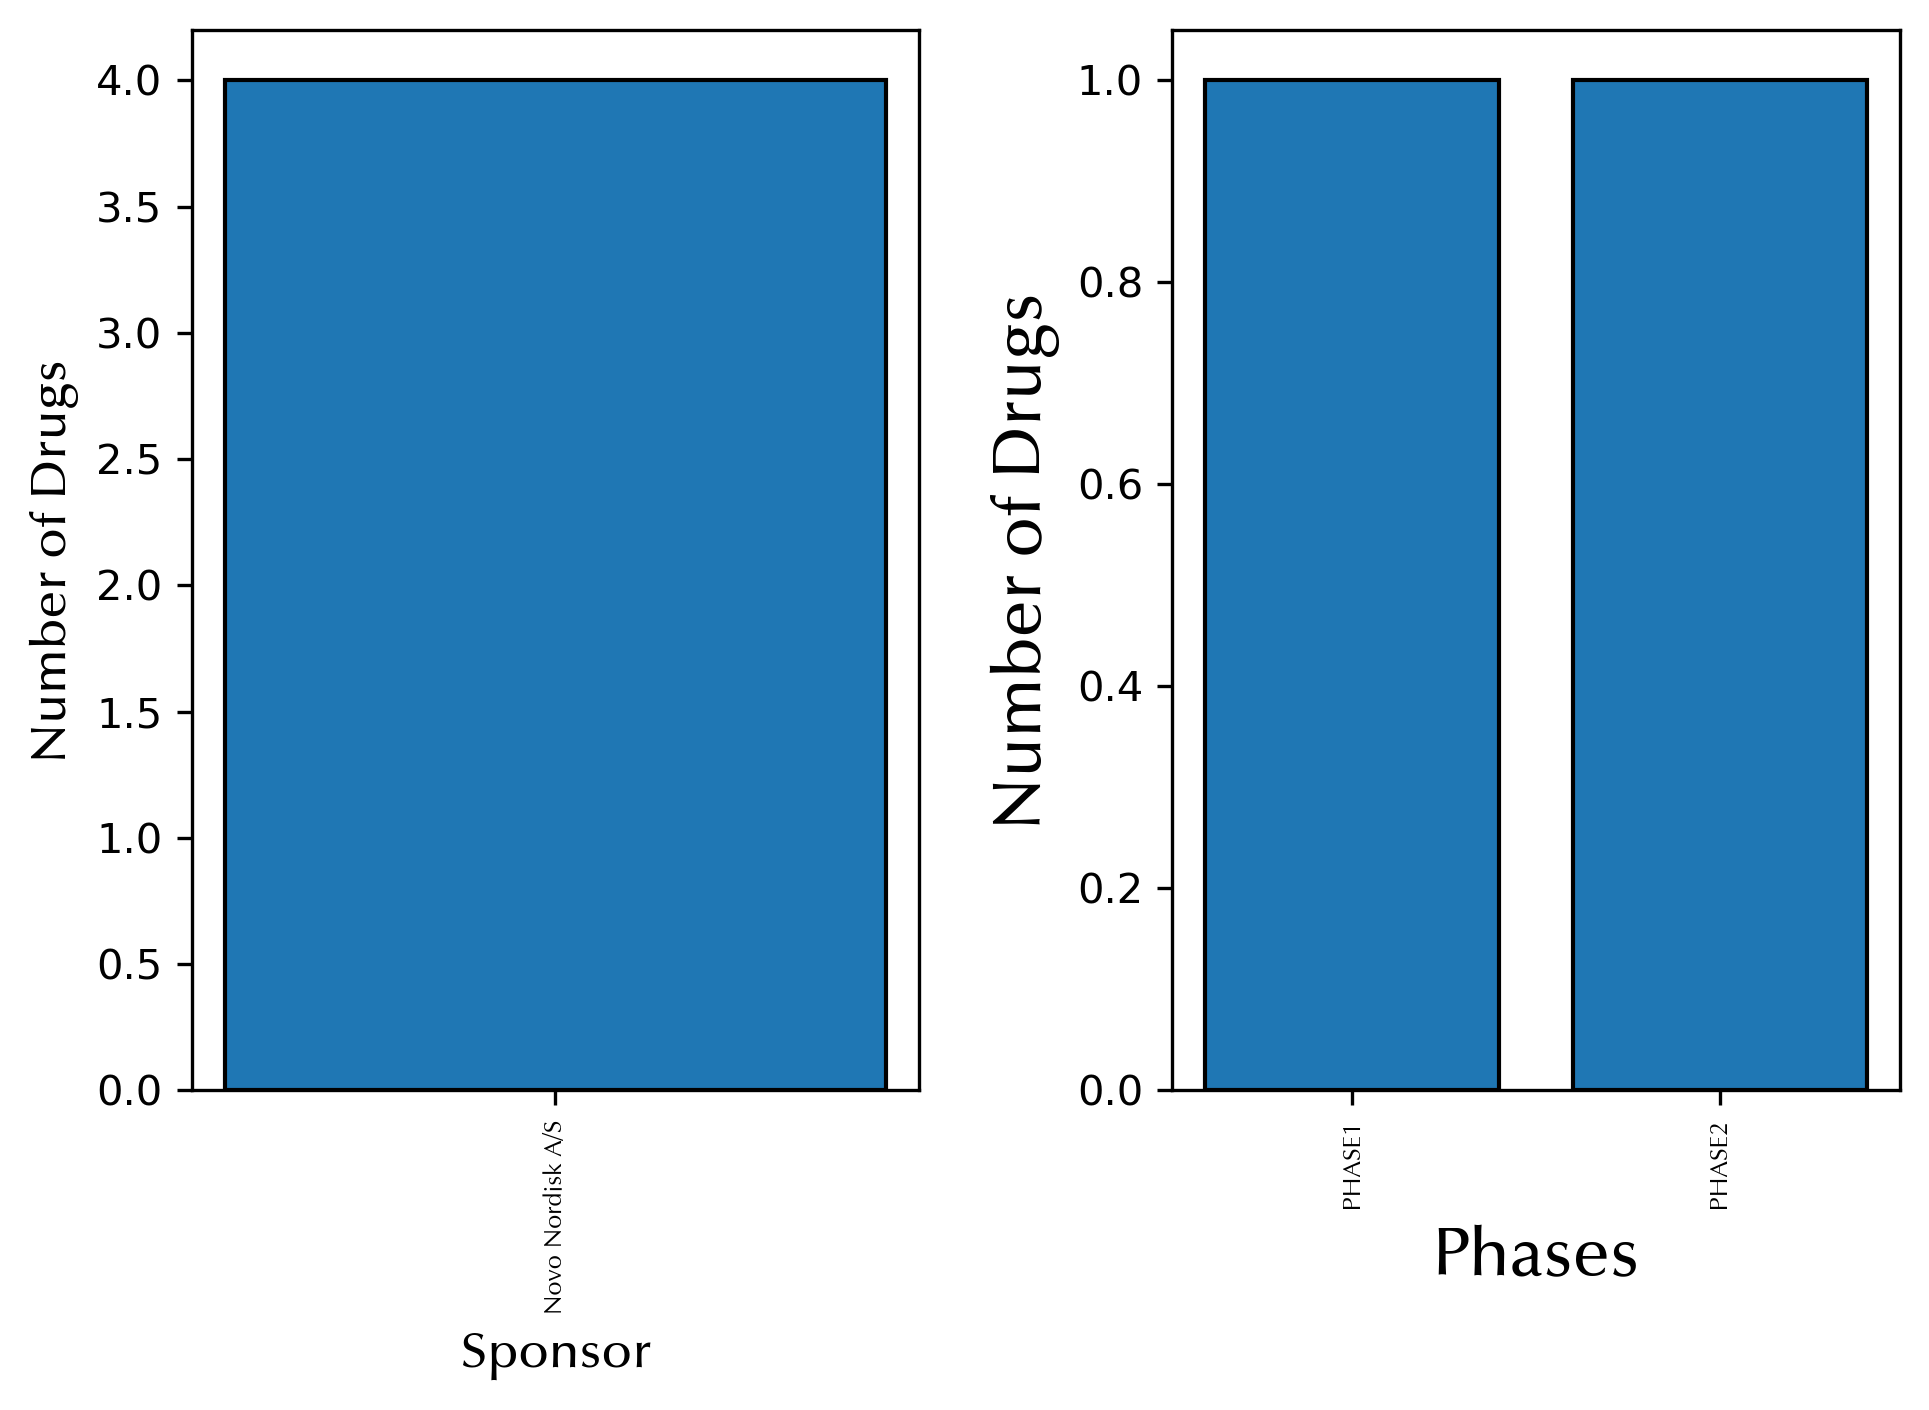

In [38]:
ctgov_df = main(
	pdf_name = 'Gate Neurosciences Series B - September 2024.pdf', 
	company_name = 'Novo Nordisk',
	drug_name = 'ozempic',
	active_ingredient = 'semaglutide',
	search_terms = ['obesity']
)